In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.layers import LSTM,Bidirectional
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error
from keras.layers.core import Activation, Dropout
from keras.callbacks import EarlyStopping
import time
from matplotlib import pyplot
import numpy
import random
from keras_self_attention import SeqSelfAttention
from tcn import TCN
import tensorflow as tf
import time
start_time = time.time()

# IMF2

<Figure size 2000x800 with 0 Axes>

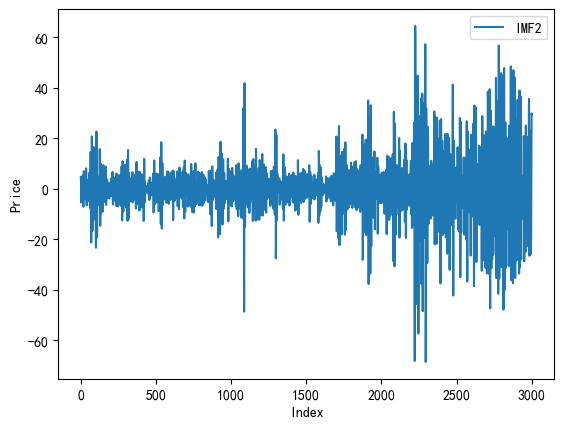

D:\anaconda3\lib\site-packages\keras\initializers\initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 3, 256)           133120    
 l)                                                              
                                                                 
 Attention (SeqSelfAttention  (None, 3, 256)           16449     
 )                                                               
                                                                 
 tcn (TCN)                   (None, 32)                39200     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 activation (Activation)     (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 3

Epoch 53/200
68/68 [==============================] - 1s 8ms/step - loss: 8.8826e-04 - mae: 0.0213 - val_loss: 0.0049 - val_mae: 0.0510
Epoch 54/200
68/68 [==============================] - 1s 8ms/step - loss: 8.4213e-04 - mae: 0.0214 - val_loss: 0.0057 - val_mae: 0.0565
Epoch 55/200
68/68 [==============================] - 1s 8ms/step - loss: 9.4879e-04 - mae: 0.0227 - val_loss: 0.0053 - val_mae: 0.0533
Epoch 56/200
68/68 [==============================] - 1s 9ms/step - loss: 8.3083e-04 - mae: 0.0209 - val_loss: 0.0057 - val_mae: 0.0550
Epoch 57/200
68/68 [==============================] - 1s 9ms/step - loss: 9.5675e-04 - mae: 0.0226 - val_loss: 0.0064 - val_mae: 0.0585
Epoch 58/200
68/68 [==============================] - 1s 9ms/step - loss: 9.0135e-04 - mae: 0.0219 - val_loss: 0.0047 - val_mae: 0.0510
Epoch 59/200
68/68 [==============================] - 1s 8ms/step - loss: 9.2825e-04 - mae: 0.0225 - val_loss: 0.0049 - val_mae: 0.0505
Epoch 60/200
68/68 [============================

68/68 [==============================] - 1s 9ms/step - loss: 4.9948e-04 - mae: 0.0163 - val_loss: 0.0035 - val_mae: 0.0420
Epoch 114/200
68/68 [==============================] - 1s 9ms/step - loss: 4.6465e-04 - mae: 0.0153 - val_loss: 0.0034 - val_mae: 0.0415
Epoch 115/200
68/68 [==============================] - 1s 9ms/step - loss: 5.5138e-04 - mae: 0.0169 - val_loss: 0.0048 - val_mae: 0.0497
Epoch 116/200
68/68 [==============================] - 1s 10ms/step - loss: 5.1381e-04 - mae: 0.0162 - val_loss: 0.0034 - val_mae: 0.0428
Epoch 117/200
68/68 [==============================] - 1s 9ms/step - loss: 5.4385e-04 - mae: 0.0172 - val_loss: 0.0035 - val_mae: 0.0419
Epoch 118/200
68/68 [==============================] - 1s 9ms/step - loss: 4.8420e-04 - mae: 0.0158 - val_loss: 0.0039 - val_mae: 0.0449
Epoch 119/200
68/68 [==============================] - 1s 9ms/step - loss: 4.5537e-04 - mae: 0.0152 - val_loss: 0.0035 - val_mae: 0.0426
Epoch 119: early stopping
75/75 [=====================

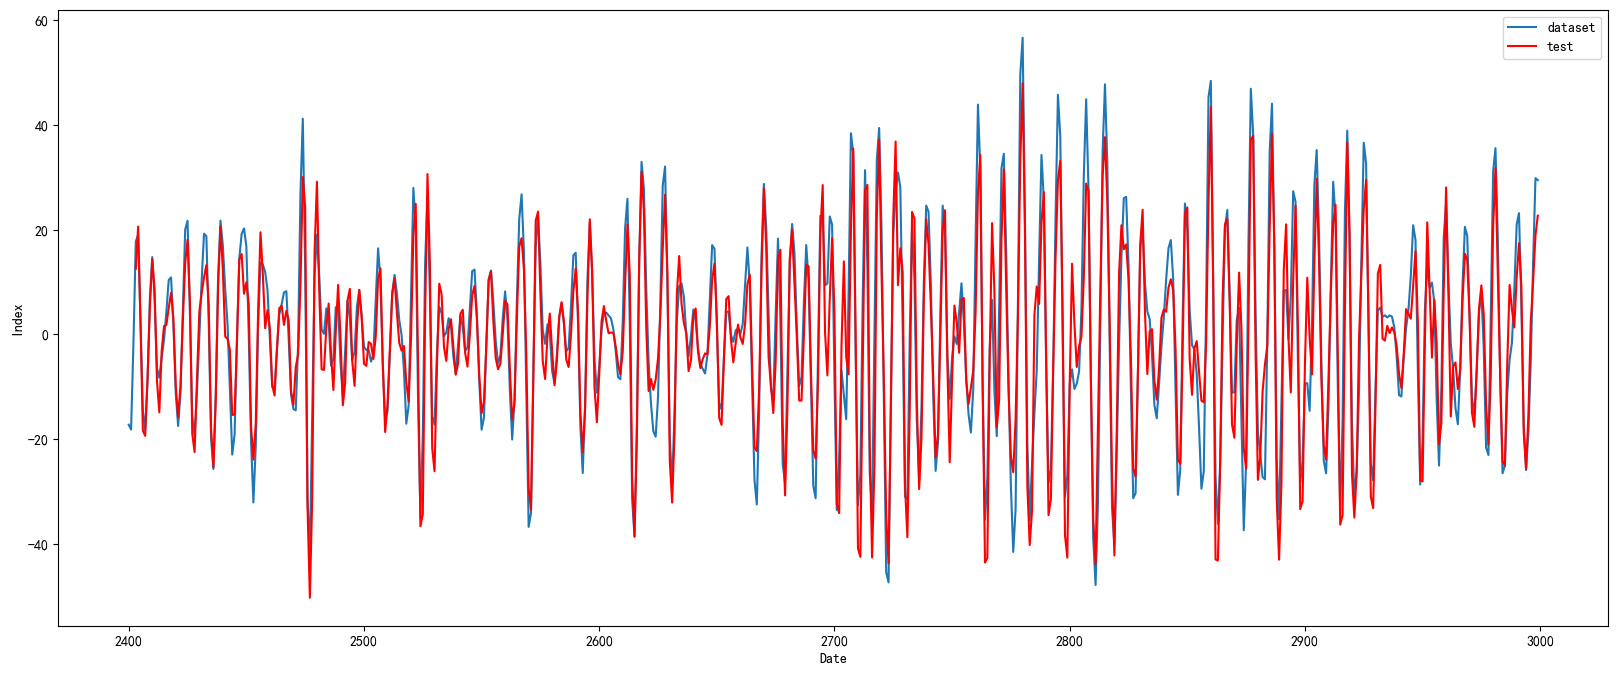

In [2]:
seed_value = 6
np.random.seed(seed_value)
random.seed(seed_value)
tf.random.set_seed(seed_value)
def create_dataset(dataset, look_back):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)
 
def mape(y_true, y_pred):
    n = len(y_true)
    mape = sum(np.abs((y_true - y_pred) / y_true)) / n * 100
    return mape
dataframe = read_csv('./ICEEMDAN S&P 500 Index Low modes_data.csv', index_col=0,usecols=[0,2])
dataset = dataframe.values
dataset = dataset.astype('float32') 
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False
plt.figure(figsize=(20,8))
dataframe.plot()
plt.xlabel('Index')
plt.ylabel('Price')
plt.yticks()
plt.legend()
plt.show()
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset.reshape(-1, 1))
train_size = int(len(dataset) * 0.8) 
test_size = len(dataset) - train_size 
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1)) 

model = Sequential()
model.add(Bidirectional(LSTM(128,return_sequences=True), input_shape=(look_back, 1)))
model.add(SeqSelfAttention(attention_activation='sigmoid', name='Attention'))
model.add(TCN(nb_filters=32, kernel_size=2, nb_stacks=1, dilations=(1, 2, 4, 8), padding='causal', use_skip_connections=True, dropout_rate=0.2, return_sequences=False, activation='linear', kernel_initializer='he_normal', use_batch_norm=False))
model.add(Dropout(0.2))
model.add(Activation('relu'))
model.add(Dense(1)) 
model.compile(loss="mse", optimizer="adam",metrics=['mae']) 
model.summary()
early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1, restore_best_weights=True)
history = model.fit(trainX, trainY, batch_size=32, epochs=200, validation_split=0.1, verbose=1, callbacks=[early_stopping])
scores=model.evaluate(trainX, trainY) 
print(scores[0],scores[1])  
testPredict = model.predict(testX)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict) 
testY = scaler.inverse_transform([testY])
IMF2_pre= pd.DataFrame(testPredict)
IMF2_true= pd.DataFrame(testY[0])

testScore_2= mape(testY[0], testPredict[:, 0])
print('Test Sccore %.4f MAPE' %(testScore_2))
testScore_0 = mean_absolute_error(testY[0], testPredict[:,0])
print('Test Score: %.4f MAE' % (testScore_0))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.4f RMSE' % (testScore))

testPredictPlot = np.empty_like(dataset) 
testPredictPlot[:, :] = np.nan
testPredictPlot = np.reshape(testPredictPlot, (dataset.shape[0], 1)) 
testPredictPlot[train_size-look_back+(look_back*2):len(dataset)+1, :] = testPredict 
plt.figure(figsize=(20,8))
plt.plot( np.arange(train_size, len(dataset), 1),scaler.inverse_transform(dataset)[train_size:], label='dataset')
plt.plot(testPredictPlot,color='r', label='test')
plt.ylabel('Index')
plt.xlabel('Date')
plt.legend()
plt.show()

# IMF3

<Figure size 2000x800 with 0 Axes>

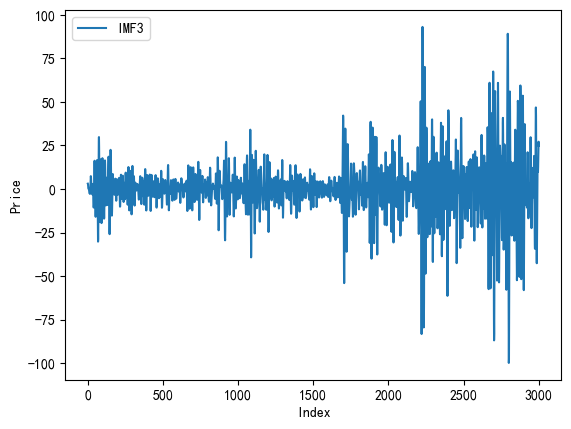

D:\anaconda3\lib\site-packages\keras\initializers\initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_1 (Bidirectio  (None, 3, 256)           133120    
 nal)                                                            
                                                                 
 Attention (SeqSelfAttention  (None, 3, 256)           16449     
 )                                                               
                                                                 
 tcn_1 (TCN)                 (None, 32)                39200     
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 activation_1 (Activation)   (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                

68/68 [==============================] - 1s 10ms/step - loss: 3.0922e-04 - mae: 0.0127 - val_loss: 0.0013 - val_mae: 0.0249
Epoch 53/100
68/68 [==============================] - 1s 9ms/step - loss: 3.3385e-04 - mae: 0.0129 - val_loss: 0.0013 - val_mae: 0.0247
Epoch 54/100
68/68 [==============================] - 1s 9ms/step - loss: 3.7863e-04 - mae: 0.0141 - val_loss: 0.0015 - val_mae: 0.0256
Epoch 55/100
68/68 [==============================] - 1s 9ms/step - loss: 3.8777e-04 - mae: 0.0152 - val_loss: 0.0013 - val_mae: 0.0248
Epoch 56/100
68/68 [==============================] - 1s 9ms/step - loss: 3.9140e-04 - mae: 0.0146 - val_loss: 0.0018 - val_mae: 0.0297
Epoch 57/100
68/68 [==============================] - 1s 9ms/step - loss: 3.0404e-04 - mae: 0.0126 - val_loss: 0.0014 - val_mae: 0.0253
Epoch 58/100
68/68 [==============================] - 1s 9ms/step - loss: 2.7839e-04 - mae: 0.0120 - val_loss: 0.0016 - val_mae: 0.0280
Epoch 59/100
68/68 [==============================] - 1s 9ms

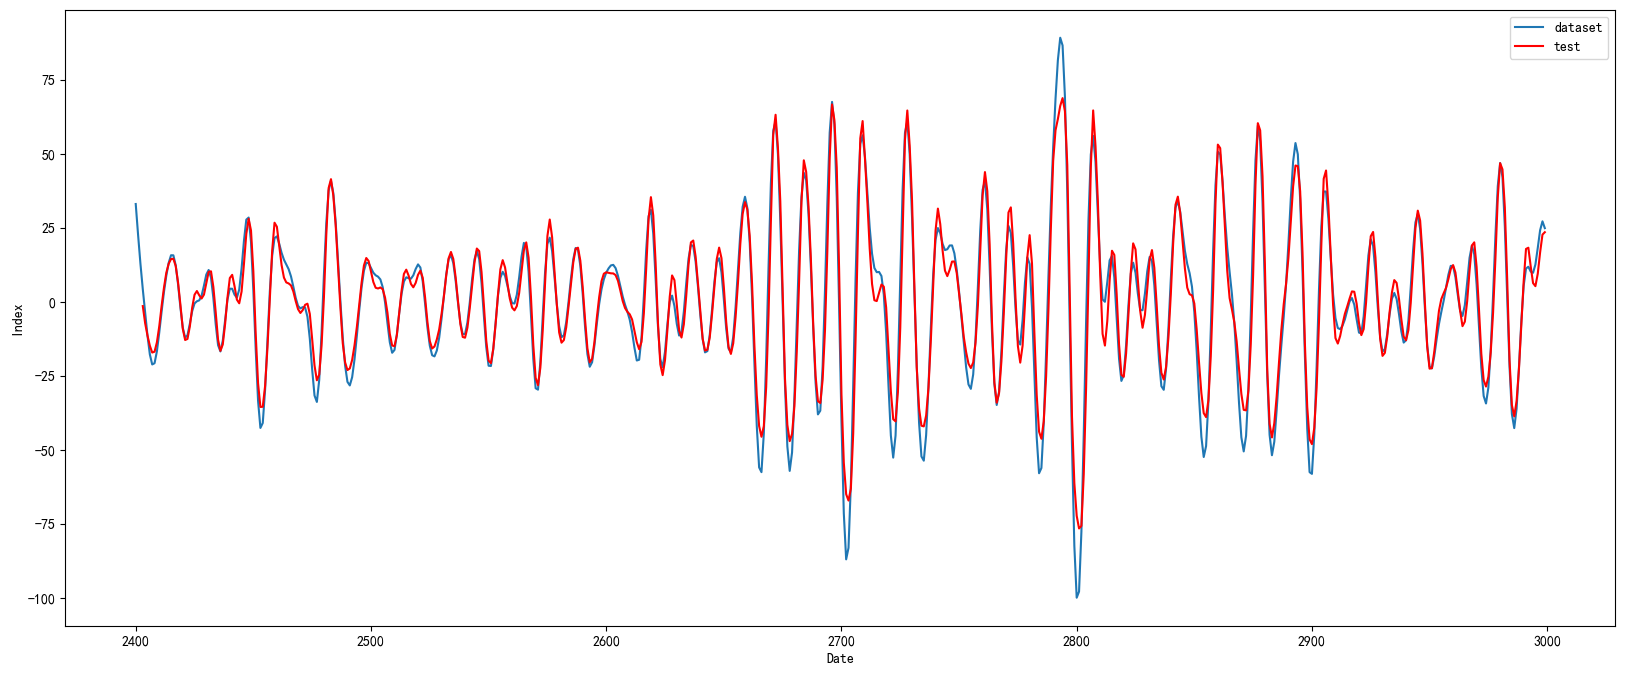

In [3]:
seed_value = 6
np.random.seed(seed_value)
random.seed(seed_value)
tf.random.set_seed(seed_value)
def create_dataset(dataset, look_back):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)
 
def mape(y_true, y_pred):
    n = len(y_true)
    mape = sum(np.abs((y_true - y_pred) / y_true)) / n * 100
    return mape
dataframe = read_csv('./ICEEMDAN S&P 500 Index Low modes_data.csv', index_col=0,usecols=[0,3])
dataset = dataframe.values
dataset = dataset.astype('float32') 
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False
plt.figure(figsize=(20,8))
dataframe.plot()
plt.xlabel('Index')
plt.ylabel('Price')
plt.yticks()
plt.legend()
plt.show()
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset.reshape(-1, 1))
train_size = int(len(dataset) * 0.8) 
test_size = len(dataset) - train_size 
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1)) 

model = Sequential()
model.add(Bidirectional(LSTM(128,return_sequences=True), input_shape=(look_back, 1)))
model.add(SeqSelfAttention(attention_activation='sigmoid', name='Attention'))
model.add(TCN(nb_filters=32, kernel_size=2, nb_stacks=1, dilations=(1, 2, 4, 8), padding='causal', use_skip_connections=True, dropout_rate=0.2, return_sequences=False, activation='linear', kernel_initializer='he_normal', use_batch_norm=False))
model.add(Dropout(0.2))
model.add(Activation('relu'))
model.add(Dense(1)) 
model.compile(loss="mse", optimizer="adam",metrics=['mae']) 
model.summary()
early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1, restore_best_weights=True)
history = model.fit(trainX, trainY, batch_size=32, epochs=100, validation_split=0.1, verbose=1, callbacks=[early_stopping])
scores=model.evaluate(trainX, trainY) 
print(scores[0],scores[1])  
testPredict = model.predict(testX)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict) 
testY = scaler.inverse_transform([testY])
IMF3_pre= pd.DataFrame(testPredict)
IMF3_true= pd.DataFrame(testY[0])

testScore_2= mape(testY[0], testPredict[:, 0])
print('Test Sccore %.4f MAPE' %(testScore_2))
testScore_0 = mean_absolute_error(testY[0], testPredict[:,0])
print('Test Score: %.4f MAE' % (testScore_0))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.4f RMSE' % (testScore))

testPredictPlot = np.empty_like(dataset) 
testPredictPlot[:, :] = np.nan
testPredictPlot = np.reshape(testPredictPlot, (dataset.shape[0], 1)) 
testPredictPlot[train_size-look_back+(look_back*2):len(dataset)+1, :] = testPredict 
plt.figure(figsize=(20,8))
plt.plot( np.arange(train_size, len(dataset), 1),scaler.inverse_transform(dataset)[train_size:], label='dataset')
plt.plot(testPredictPlot,color='r', label='test')
plt.ylabel('Index')
plt.xlabel('Date')
plt.legend()
plt.show()

# IMF4

<Figure size 2000x800 with 0 Axes>

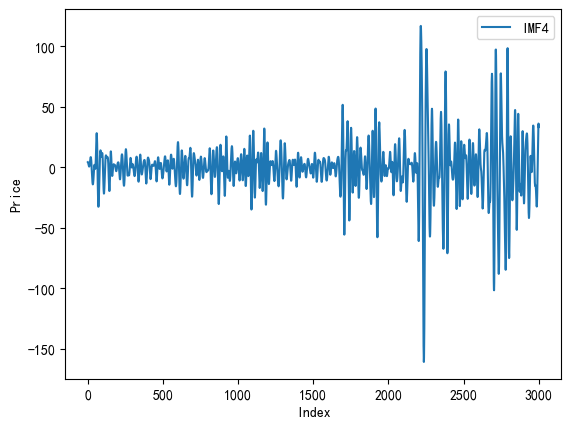

D:\anaconda3\lib\site-packages\keras\initializers\initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_2 (Bidirectio  (None, 3, 256)           133120    
 nal)                                                            
                                                                 
 Attention (SeqSelfAttention  (None, 3, 256)           16449     
 )                                                               
                                                                 
 tcn_2 (TCN)                 (None, 32)                39200     
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 activation_2 (Activation)   (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                

68/68 [==============================] - 1s 13ms/step - loss: 2.9546e-04 - mae: 0.0131 - val_loss: 0.0014 - val_mae: 0.0278
Epoch 53/100
68/68 [==============================] - 1s 10ms/step - loss: 2.8389e-04 - mae: 0.0126 - val_loss: 9.6341e-04 - val_mae: 0.0226
Epoch 54/100
68/68 [==============================] - 1s 9ms/step - loss: 3.3455e-04 - mae: 0.0138 - val_loss: 7.7689e-04 - val_mae: 0.0204
Epoch 55/100
68/68 [==============================] - 1s 10ms/step - loss: 2.5756e-04 - mae: 0.0122 - val_loss: 8.1079e-04 - val_mae: 0.0205
Epoch 56/100
68/68 [==============================] - 1s 10ms/step - loss: 3.3543e-04 - mae: 0.0138 - val_loss: 0.0015 - val_mae: 0.0295
Epoch 57/100
68/68 [==============================] - 1s 9ms/step - loss: 2.8088e-04 - mae: 0.0124 - val_loss: 0.0011 - val_mae: 0.0251
Epoch 58/100
68/68 [==============================] - 1s 9ms/step - loss: 2.4063e-04 - mae: 0.0116 - val_loss: 6.5116e-04 - val_mae: 0.0178
Epoch 59/100
68/68 [=====================

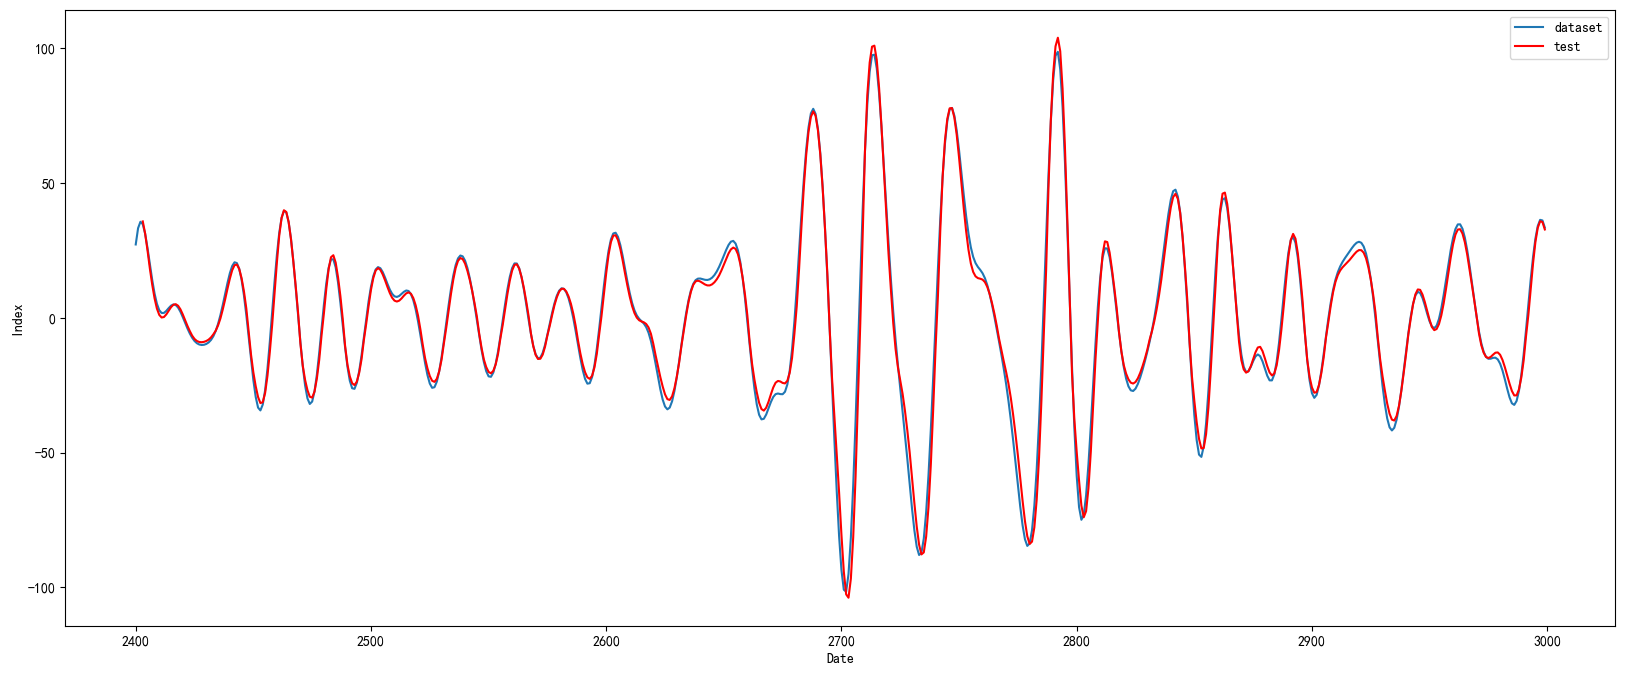

In [4]:
seed_value = 42
np.random.seed(seed_value)
random.seed(seed_value)
tf.random.set_seed(seed_value)
def create_dataset(dataset, look_back):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)
 
def mape(y_true, y_pred):
    n = len(y_true)
    mape = sum(np.abs((y_true - y_pred) / y_true)) / n * 100
    return mape
dataframe = read_csv('./ICEEMDAN S&P 500 Index Low modes_data.csv', index_col=0,usecols=[0,4])
dataset = dataframe.values
dataset = dataset.astype('float32') 
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False
plt.figure(figsize=(20,8))
dataframe.plot()
plt.xlabel('Index')
plt.ylabel('Price')
plt.yticks()
plt.legend()
plt.show()
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset.reshape(-1, 1))
train_size = int(len(dataset) * 0.8) 
test_size = len(dataset) - train_size 
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1)) 

model = Sequential()
model.add(Bidirectional(LSTM(128,return_sequences=True), input_shape=(look_back, 1)))
model.add(SeqSelfAttention(attention_activation='sigmoid', name='Attention'))
model.add(TCN(nb_filters=32, kernel_size=2, nb_stacks=1, dilations=(1, 2, 4, 8), padding='causal', use_skip_connections=True, dropout_rate=0.2, return_sequences=False, activation='linear', kernel_initializer='he_normal', use_batch_norm=False))
model.add(Dropout(0.2))
model.add(Activation('relu'))
model.add(Dense(1)) 
model.compile(loss="mse", optimizer="adam",metrics=['mae']) 
model.summary()
early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1, restore_best_weights=True)
history = model.fit(trainX, trainY, batch_size=32, epochs=100, validation_split=0.1, verbose=1, callbacks=[early_stopping])
scores=model.evaluate(trainX, trainY) 
print(scores[0],scores[1])  
testPredict = model.predict(testX)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict) 
testY = scaler.inverse_transform([testY])
IMF4_pre= pd.DataFrame(testPredict)
IMF4_true= pd.DataFrame(testY[0])

testScore_2= mape(testY[0], testPredict[:, 0])
print('Test Sccore %.4f MAPE' %(testScore_2))
testScore_0 = mean_absolute_error(testY[0], testPredict[:,0])
print('Test Score: %.4f MAE' % (testScore_0))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.4f RMSE' % (testScore))

testPredictPlot = np.empty_like(dataset) 
testPredictPlot[:, :] = np.nan
testPredictPlot = np.reshape(testPredictPlot, (dataset.shape[0], 1)) 
testPredictPlot[train_size-look_back+(look_back*2):len(dataset)+1, :] = testPredict 
plt.figure(figsize=(20,8))
plt.plot( np.arange(train_size, len(dataset), 1),scaler.inverse_transform(dataset)[train_size:], label='dataset')
plt.plot(testPredictPlot,color='r', label='test')
plt.ylabel('Index')
plt.xlabel('Date')
plt.legend()
plt.show()

# IMF5

<Figure size 2000x800 with 0 Axes>

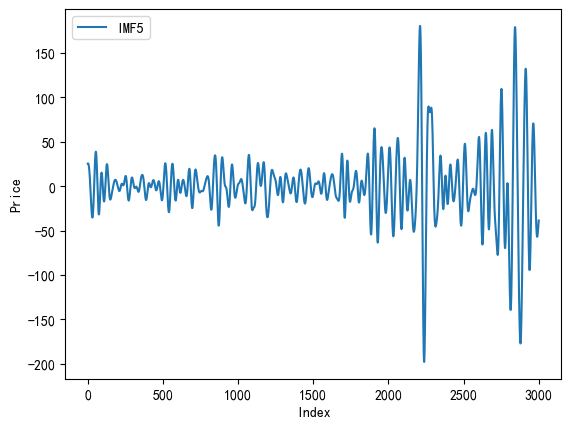

D:\anaconda3\lib\site-packages\keras\initializers\initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_3 (Bidirectio  (None, 3, 128)           33792     
 nal)                                                            
                                                                 
 Attention (SeqSelfAttention  (None, 3, 128)           8257      
 )                                                               
                                                                 
 tcn_3 (TCN)                 (None, 32)                26912     
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 activation_3 (Activation)   (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                

68/68 [==============================] - 1s 8ms/step - loss: 3.1162e-04 - mae: 0.0135 - val_loss: 0.0012 - val_mae: 0.0247
Epoch 53/200
68/68 [==============================] - 1s 9ms/step - loss: 3.2587e-04 - mae: 0.0138 - val_loss: 0.0012 - val_mae: 0.0249
Epoch 54/200
68/68 [==============================] - 1s 8ms/step - loss: 3.4674e-04 - mae: 0.0137 - val_loss: 0.0018 - val_mae: 0.0315
Epoch 55/200
68/68 [==============================] - 1s 7ms/step - loss: 3.2612e-04 - mae: 0.0141 - val_loss: 0.0015 - val_mae: 0.0280
Epoch 56/200
68/68 [==============================] - 0s 7ms/step - loss: 3.2380e-04 - mae: 0.0134 - val_loss: 0.0017 - val_mae: 0.0277
Epoch 57/200
68/68 [==============================] - 0s 7ms/step - loss: 3.0088e-04 - mae: 0.0131 - val_loss: 0.0017 - val_mae: 0.0287
Epoch 58/200
68/68 [==============================] - 1s 7ms/step - loss: 2.9714e-04 - mae: 0.0132 - val_loss: 0.0014 - val_mae: 0.0256
Epoch 59/200
68/68 [==============================] - 1s 8ms/

68/68 [==============================] - 1s 7ms/step - loss: 1.3385e-04 - mae: 0.0084 - val_loss: 4.0495e-04 - val_mae: 0.0138
Epoch 112/200
68/68 [==============================] - 1s 8ms/step - loss: 1.1816e-04 - mae: 0.0080 - val_loss: 3.7095e-04 - val_mae: 0.0144
Epoch 113/200
68/68 [==============================] - 1s 7ms/step - loss: 1.8358e-04 - mae: 0.0103 - val_loss: 9.1079e-04 - val_mae: 0.0226
Epoch 114/200
68/68 [==============================] - 1s 7ms/step - loss: 1.3577e-04 - mae: 0.0087 - val_loss: 4.9170e-04 - val_mae: 0.0153
Epoch 115/200
68/68 [==============================] - 1s 7ms/step - loss: 1.5040e-04 - mae: 0.0091 - val_loss: 4.7084e-04 - val_mae: 0.0159
Epoch 116/200
68/68 [==============================] - 1s 7ms/step - loss: 1.2201e-04 - mae: 0.0079 - val_loss: 5.8777e-04 - val_mae: 0.0162
Epoch 117/200
68/68 [==============================] - 1s 8ms/step - loss: 1.5220e-04 - mae: 0.0093 - val_loss: 5.6686e-04 - val_mae: 0.0160
Epoch 118/200
68/68 [======

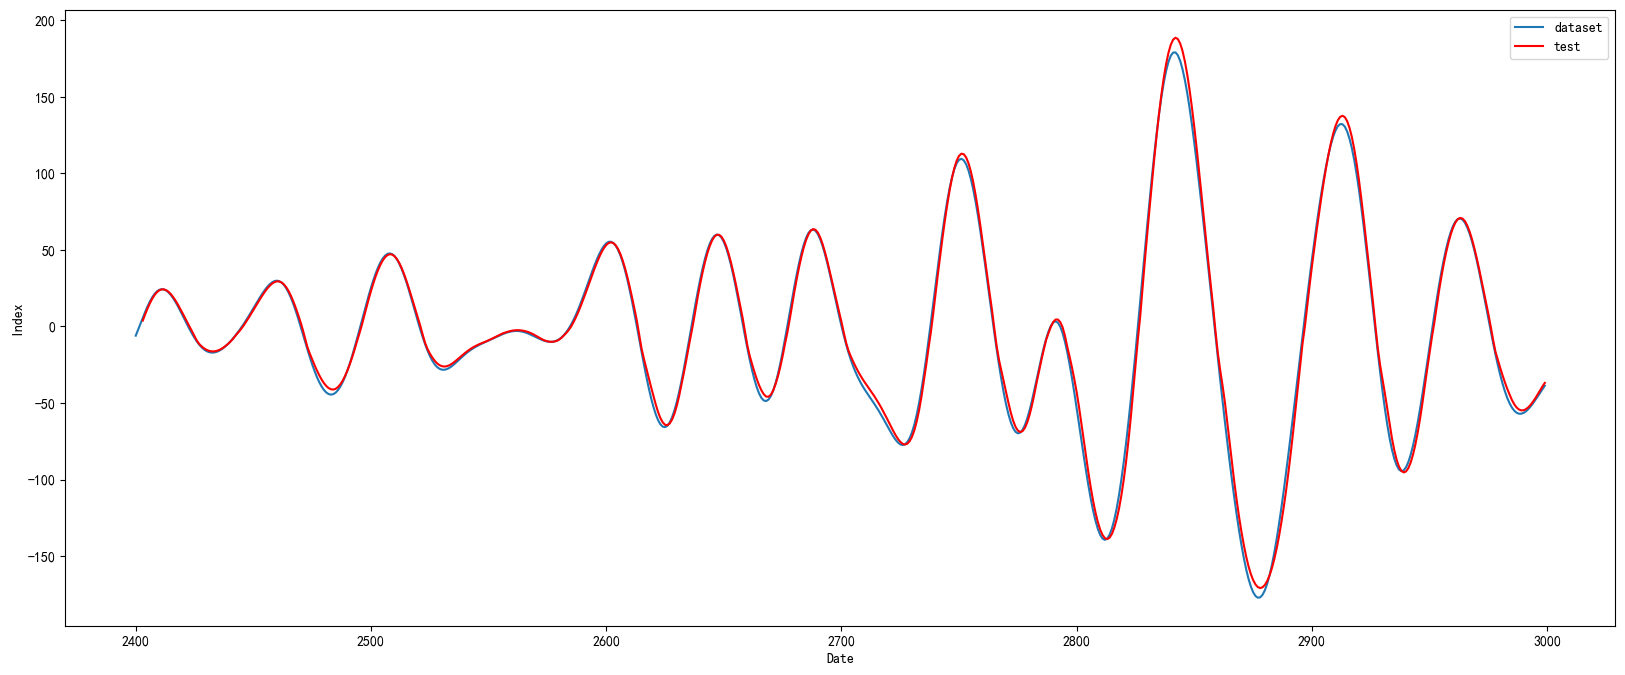

In [5]:
seed_value = 42
np.random.seed(seed_value)
random.seed(seed_value)
tf.random.set_seed(seed_value)
def create_dataset(dataset, look_back):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)
 
def mape(y_true, y_pred):
    n = len(y_true)
    mape = sum(np.abs((y_true - y_pred) / y_true)) / n * 100
    return mape
dataframe = read_csv('./ICEEMDAN S&P 500 Index Low modes_data.csv', index_col=0,usecols=[0,5])
dataset = dataframe.values
dataset = dataset.astype('float32') 
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False
plt.figure(figsize=(20,8))
dataframe.plot()
plt.xlabel('Index')
plt.ylabel('Price')
plt.yticks()
plt.legend()
plt.show()
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset.reshape(-1, 1))
train_size = int(len(dataset) * 0.8) 
test_size = len(dataset) - train_size 
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1)) 

model = Sequential()
model.add(Bidirectional(LSTM(64,return_sequences=True), input_shape=(look_back, 1)))
model.add(SeqSelfAttention(attention_activation='sigmoid', name='Attention'))
model.add(TCN(nb_filters=32, kernel_size=2, nb_stacks=1, dilations=(1, 2, 4, 8), padding='causal', use_skip_connections=True, dropout_rate=0.2, return_sequences=False, activation='linear', kernel_initializer='he_normal', use_batch_norm=False))
model.add(Dropout(0.2))
model.add(Activation('relu'))
model.add(Dense(1)) 
model.compile(loss="mse", optimizer="adam",metrics=['mae']) 
model.summary()
early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1, restore_best_weights=True)
history = model.fit(trainX, trainY, batch_size=32, epochs=200, validation_split=0.1, verbose=1, callbacks=[early_stopping])
scores=model.evaluate(trainX, trainY) 
print(scores[0],scores[1])  
testPredict = model.predict(testX)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict) 
testY = scaler.inverse_transform([testY])
IMF5_pre= pd.DataFrame(testPredict)
IMF5_true= pd.DataFrame(testY[0])

testScore_2= mape(testY[0], testPredict[:, 0])
print('Test Sccore %.4f MAPE' %(testScore_2))
testScore_0 = mean_absolute_error(testY[0], testPredict[:,0])
print('Test Score: %.4f MAE' % (testScore_0))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.4f RMSE' % (testScore))

testPredictPlot = np.empty_like(dataset) 
testPredictPlot[:, :] = np.nan
testPredictPlot = np.reshape(testPredictPlot, (dataset.shape[0], 1)) 
testPredictPlot[train_size-look_back+(look_back*2):len(dataset)+1, :] = testPredict 
plt.figure(figsize=(20,8))
plt.plot( np.arange(train_size, len(dataset), 1),scaler.inverse_transform(dataset)[train_size:], label='dataset')
plt.plot(testPredictPlot,color='r', label='test')
plt.ylabel('Index')
plt.xlabel('Date')
plt.legend()
plt.show()

# IMF6

<Figure size 2000x800 with 0 Axes>

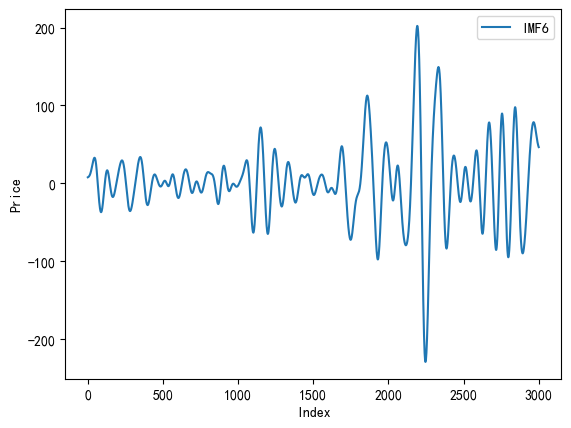

D:\anaconda3\lib\site-packages\keras\initializers\initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_4 (Bidirectio  (None, 3, 256)           133120    
 nal)                                                            
                                                                 
 Attention (SeqSelfAttention  (None, 3, 256)           16449     
 )                                                               
                                                                 
 tcn_4 (TCN)                 (None, 32)                39200     
                                                                 
 dropout_4 (Dropout)         (None, 32)                0         
                                                                 
 activation_4 (Activation)   (None, 32)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                

Epoch 52/200
68/68 [==============================] - 1s 9ms/step - loss: 3.3197e-04 - mae: 0.0130 - val_loss: 0.0011 - val_mae: 0.0261
Epoch 53/200
68/68 [==============================] - 1s 10ms/step - loss: 3.5497e-04 - mae: 0.0137 - val_loss: 8.4193e-04 - val_mae: 0.0246
Epoch 54/200
68/68 [==============================] - 1s 10ms/step - loss: 3.5246e-04 - mae: 0.0135 - val_loss: 0.0014 - val_mae: 0.0293
Epoch 55/200
68/68 [==============================] - 1s 10ms/step - loss: 3.1822e-04 - mae: 0.0128 - val_loss: 8.8894e-04 - val_mae: 0.0258
Epoch 56/200
68/68 [==============================] - 1s 10ms/step - loss: 3.7000e-04 - mae: 0.0143 - val_loss: 9.8034e-04 - val_mae: 0.0248
Epoch 57/200
68/68 [==============================] - 1s 10ms/step - loss: 3.6792e-04 - mae: 0.0137 - val_loss: 7.2918e-04 - val_mae: 0.0228
Epoch 58/200
68/68 [==============================] - 1s 10ms/step - loss: 3.5719e-04 - mae: 0.0134 - val_loss: 9.8252e-04 - val_mae: 0.0267
Epoch 59/200
68/68 [==

68/68 [==============================] - 1s 10ms/step - loss: 2.2127e-04 - mae: 0.0103 - val_loss: 6.8277e-04 - val_mae: 0.0226
Epoch 111/200
68/68 [==============================] - 1s 10ms/step - loss: 1.8263e-04 - mae: 0.0093 - val_loss: 7.2310e-04 - val_mae: 0.0232
Epoch 112/200
68/68 [==============================] - 1s 9ms/step - loss: 1.7484e-04 - mae: 0.0095 - val_loss: 8.9205e-04 - val_mae: 0.0249
Epoch 113/200
68/68 [==============================] - 1s 10ms/step - loss: 1.9703e-04 - mae: 0.0095 - val_loss: 6.1240e-04 - val_mae: 0.0206
Epoch 114/200
68/68 [==============================] - 1s 10ms/step - loss: 1.8811e-04 - mae: 0.0095 - val_loss: 7.2793e-04 - val_mae: 0.0212
Epoch 115/200
68/68 [==============================] - 1s 10ms/step - loss: 1.9780e-04 - mae: 0.0097 - val_loss: 4.6339e-04 - val_mae: 0.0182
Epoch 116/200
68/68 [==============================] - 1s 10ms/step - loss: 1.9021e-04 - mae: 0.0094 - val_loss: 4.5067e-04 - val_mae: 0.0178
Epoch 117/200
68/68 [

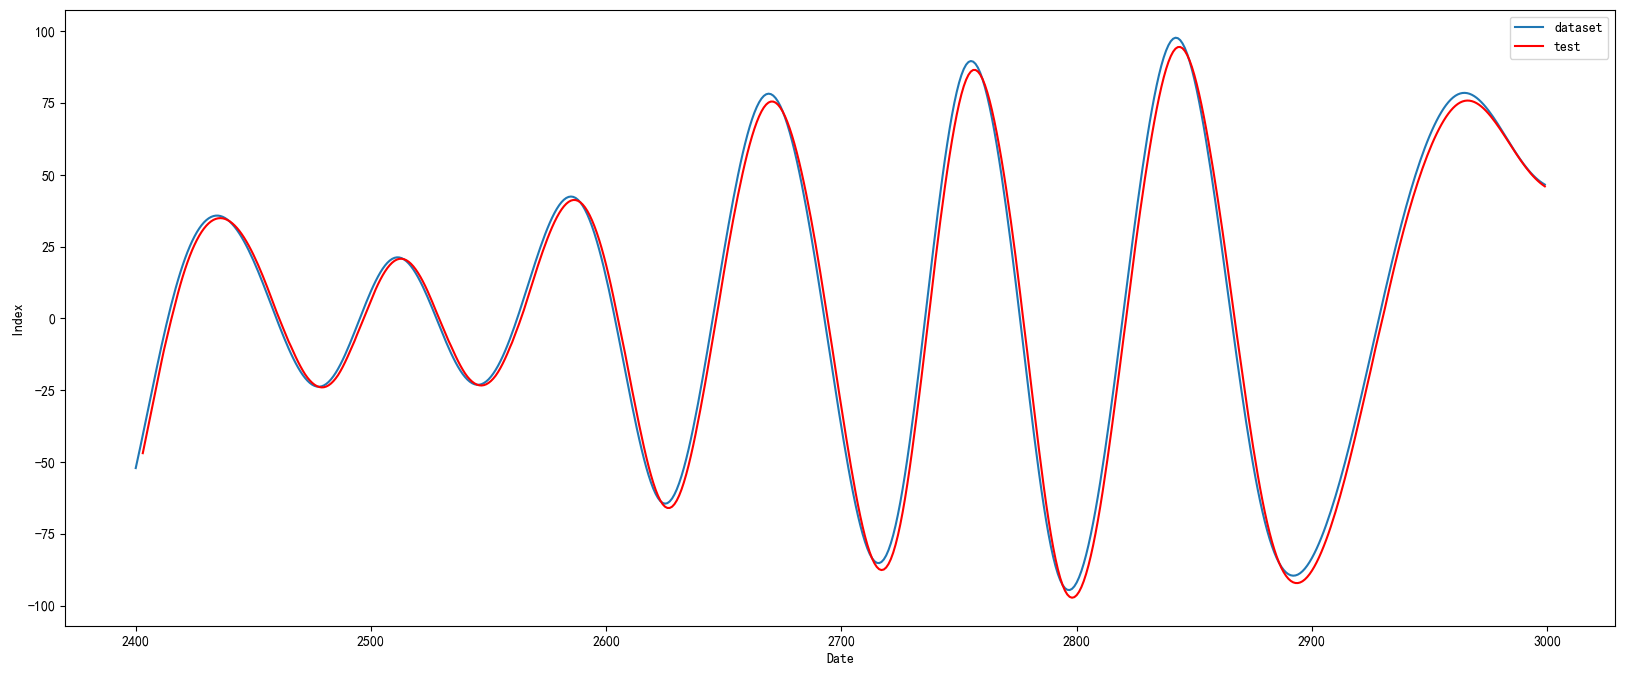

In [6]:
seed_value = 42
np.random.seed(seed_value)
random.seed(seed_value)
tf.random.set_seed(seed_value)
def create_dataset(dataset, look_back):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)
 
def mape(y_true, y_pred):
    n = len(y_true)
    mape = sum(np.abs((y_true - y_pred) / y_true)) / n * 100
    return mape
dataframe = read_csv('./ICEEMDAN S&P 500 Index Low modes_data.csv', index_col=0,usecols=[0,6])
dataset = dataframe.values
dataset = dataset.astype('float32') 
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False
plt.figure(figsize=(20,8))
dataframe.plot()
plt.xlabel('Index')
plt.ylabel('Price')
plt.yticks()
plt.legend()
plt.show()
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset.reshape(-1, 1))
train_size = int(len(dataset) * 0.8) 
test_size = len(dataset) - train_size 
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1)) 

model = Sequential()
model.add(Bidirectional(LSTM(128,return_sequences=True), input_shape=(look_back, 1)))
model.add(SeqSelfAttention(attention_activation='sigmoid', name='Attention'))
model.add(TCN(nb_filters=32, kernel_size=2, nb_stacks=1, dilations=(1, 2, 4, 8), padding='causal', use_skip_connections=True, dropout_rate=0.2, return_sequences=False, activation='linear', kernel_initializer='he_normal', use_batch_norm=False))
model.add(Dropout(0.2))
model.add(Activation('relu'))
model.add(Dense(1)) 
model.compile(loss="mse", optimizer="adam",metrics=['mae']) 
model.summary()
early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1, restore_best_weights=True)
history = model.fit(trainX, trainY, batch_size=32, epochs=200, validation_split=0.1, verbose=1, callbacks=[early_stopping])
scores=model.evaluate(trainX, trainY) 
print(scores[0],scores[1])  
testPredict = model.predict(testX)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict) 
testY = scaler.inverse_transform([testY])
IMF6_pre= pd.DataFrame(testPredict)
IMF6_true= pd.DataFrame(testY[0])

testScore_2= mape(testY[0], testPredict[:, 0])
print('Test Sccore %.4f MAPE' %(testScore_2))
testScore_0 = mean_absolute_error(testY[0], testPredict[:,0])
print('Test Score: %.4f MAE' % (testScore_0))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.4f RMSE' % (testScore))

testPredictPlot = np.empty_like(dataset) 
testPredictPlot[:, :] = np.nan
testPredictPlot = np.reshape(testPredictPlot, (dataset.shape[0], 1)) 
testPredictPlot[train_size-look_back+(look_back*2):len(dataset)+1, :] = testPredict 
plt.figure(figsize=(20,8))
plt.plot( np.arange(train_size, len(dataset), 1),scaler.inverse_transform(dataset)[train_size:], label='dataset')
plt.plot(testPredictPlot,color='r', label='test')
plt.ylabel('Index')
plt.xlabel('Date')
plt.legend()
plt.show()

# IMF7

<Figure size 2000x800 with 0 Axes>

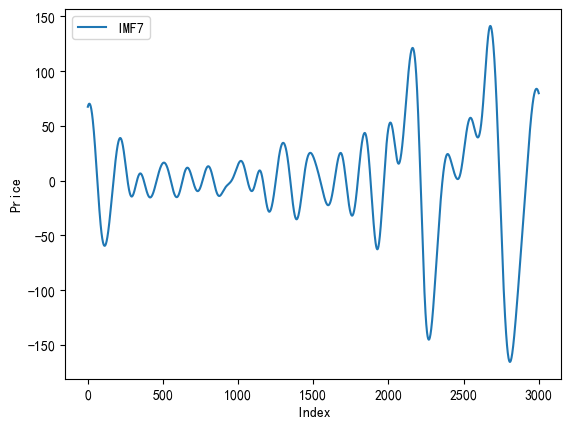

D:\anaconda3\lib\site-packages\keras\initializers\initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_5 (Bidirectio  (None, 3, 256)           133120    
 nal)                                                            
                                                                 
 Attention (SeqSelfAttention  (None, 3, 256)           16449     
 )                                                               
                                                                 
 tcn_5 (TCN)                 (None, 32)                39200     
                                                                 
 dropout_5 (Dropout)         (None, 32)                0         
                                                                 
 activation_5 (Activation)   (None, 32)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                

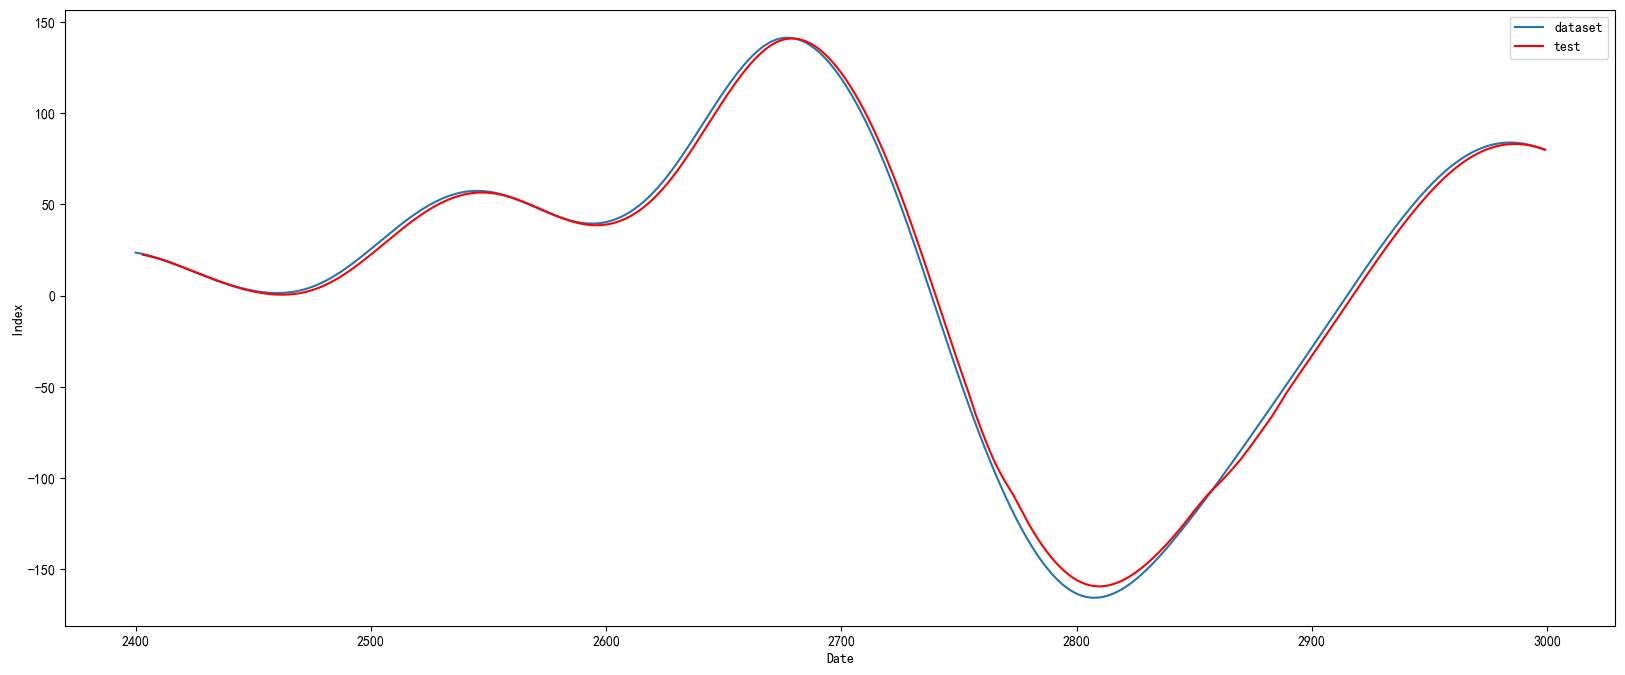

In [7]:
seed_value = 5
np.random.seed(seed_value)
random.seed(seed_value)
tf.random.set_seed(seed_value)
def create_dataset(dataset, look_back):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)
 
def mape(y_true, y_pred):
    n = len(y_true)
    mape = sum(np.abs((y_true - y_pred) / y_true)) / n * 100
    return mape
dataframe = read_csv('./ICEEMDAN S&P 500 Index Low modes_data.csv', index_col=0,usecols=[0,7])
dataset = dataframe.values
dataset = dataset.astype('float32') 
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False
plt.figure(figsize=(20,8))
dataframe.plot()
plt.xlabel('Index')
plt.ylabel('Price')
plt.yticks()
plt.legend()
plt.show()
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset.reshape(-1, 1))
train_size = int(len(dataset) * 0.8) 
test_size = len(dataset) - train_size 
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1)) 

model = Sequential()
model.add(Bidirectional(LSTM(128,return_sequences=True), input_shape=(look_back, 1)))
model.add(SeqSelfAttention(attention_activation='sigmoid', name='Attention'))
model.add(TCN(nb_filters=32, kernel_size=2, nb_stacks=1, dilations=(1, 2, 4, 8), padding='causal', use_skip_connections=True, dropout_rate=0.2, return_sequences=False, activation='linear', kernel_initializer='he_normal', use_batch_norm=False))
model.add(Dropout(0.2))
model.add(Activation('relu'))
model.add(Dense(1)) 
model.compile(loss="mse", optimizer="adam",metrics=['mae']) 
model.summary()
early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1, restore_best_weights=True)
history = model.fit(trainX, trainY, batch_size=32, epochs=100, validation_split=0.1, verbose=1, callbacks=[early_stopping])
scores=model.evaluate(trainX, trainY) 
print(scores[0],scores[1])  
testPredict = model.predict(testX)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict) 
testY = scaler.inverse_transform([testY])
IMF7_pre= pd.DataFrame(testPredict)
IMF7_true= pd.DataFrame(testY[0])

testScore_2= mape(testY[0], testPredict[:, 0])
print('Test Sccore %.4f MAPE' %(testScore_2))
testScore_0 = mean_absolute_error(testY[0], testPredict[:,0])
print('Test Score: %.4f MAE' % (testScore_0))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.4f RMSE' % (testScore))

testPredictPlot = np.empty_like(dataset) 
testPredictPlot[:, :] = np.nan
testPredictPlot = np.reshape(testPredictPlot, (dataset.shape[0], 1)) 
testPredictPlot[train_size-look_back+(look_back*2):len(dataset)+1, :] = testPredict 
plt.figure(figsize=(20,8))
plt.plot( np.arange(train_size, len(dataset), 1),scaler.inverse_transform(dataset)[train_size:], label='dataset')
plt.plot(testPredictPlot,color='r', label='test')
plt.ylabel('Index')
plt.xlabel('Date')
plt.legend()
plt.show()

# IMF8

<Figure size 2000x800 with 0 Axes>

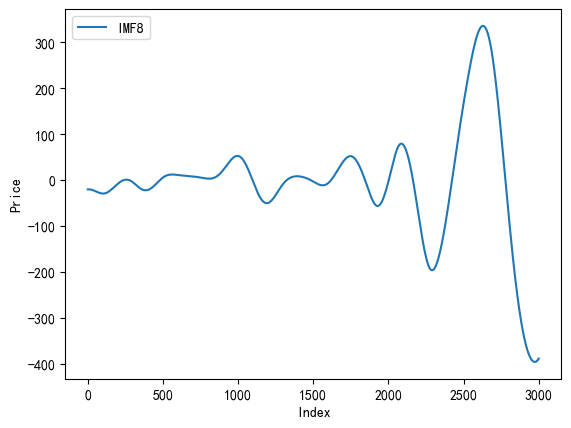

D:\anaconda3\lib\site-packages\keras\initializers\initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_6 (Bidirectio  (None, 3, 128)           33792     
 nal)                                                            
                                                                 
 Attention (SeqSelfAttention  (None, 3, 128)           8257      
 )                                                               
                                                                 
 tcn_6 (TCN)                 (None, 32)                26912     
                                                                 
 dropout_6 (Dropout)         (None, 32)                0         
                                                                 
 activation_6 (Activation)   (None, 32)                0         
                                                                 
 dense_6 (Dense)             (None, 1)                

135/135 [==============================] - 1s 7ms/step - loss: 1.1906e-04 - mae: 0.0081 - val_loss: 2.9662e-04 - val_mae: 0.0156
Epoch 51/100
135/135 [==============================] - 1s 7ms/step - loss: 1.3330e-04 - mae: 0.0087 - val_loss: 9.1916e-04 - val_mae: 0.0291
Epoch 52/100
135/135 [==============================] - 1s 7ms/step - loss: 1.0914e-04 - mae: 0.0078 - val_loss: 3.4247e-04 - val_mae: 0.0150
Epoch 53/100
135/135 [==============================] - 1s 7ms/step - loss: 1.1973e-04 - mae: 0.0080 - val_loss: 6.9597e-04 - val_mae: 0.0245
Epoch 54/100
135/135 [==============================] - 1s 8ms/step - loss: 1.0319e-04 - mae: 0.0072 - val_loss: 1.5834e-04 - val_mae: 0.0101
Epoch 55/100
135/135 [==============================] - 1s 7ms/step - loss: 9.9906e-05 - mae: 0.0073 - val_loss: 5.9202e-05 - val_mae: 0.0061
Epoch 56/100
135/135 [==============================] - 1s 7ms/step - loss: 9.4999e-05 - mae: 0.0070 - val_loss: 8.2949e-04 - val_mae: 0.0268
Epoch 57/100
135/13

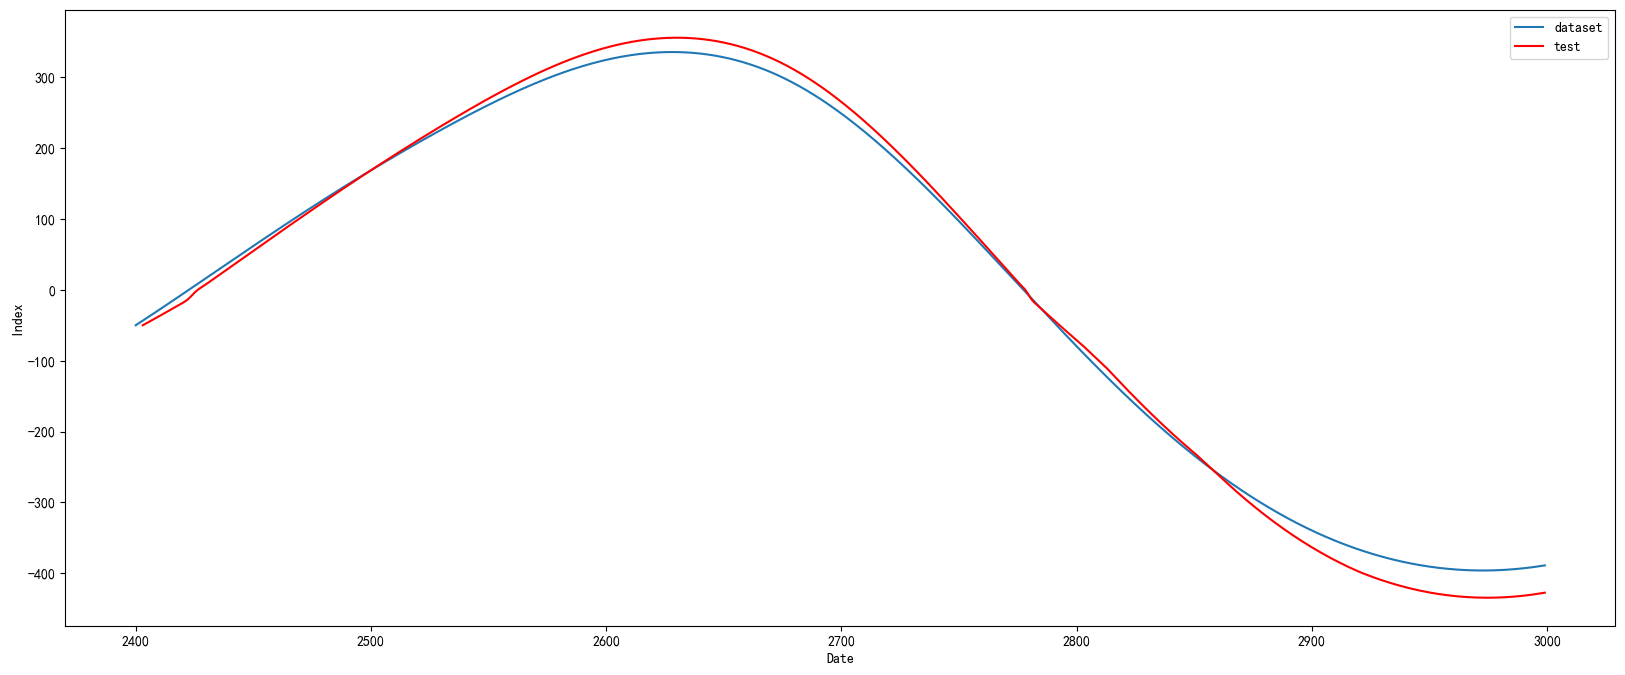

In [8]:
seed_value = 5
np.random.seed(seed_value)
random.seed(seed_value)
tf.random.set_seed(seed_value)
def create_dataset(dataset, look_back):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)
 
def mape(y_true, y_pred):
    n = len(y_true)
    mape = sum(np.abs((y_true - y_pred) / y_true)) / n * 100
    return mape
dataframe = read_csv('./ICEEMDAN S&P 500 Index Low modes_data.csv', index_col=0,usecols=[0,8])
dataset = dataframe.values
dataset = dataset.astype('float32') 
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False
plt.figure(figsize=(20,8))
dataframe.plot()
plt.xlabel('Index')
plt.ylabel('Price')
plt.yticks()
plt.legend()
plt.show()
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset.reshape(-1, 1))
train_size = int(len(dataset) * 0.8) 
test_size = len(dataset) - train_size 
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1)) 

model = Sequential()
model.add(Bidirectional(LSTM(64,return_sequences=True), input_shape=(look_back, 1)))
model.add(SeqSelfAttention(attention_activation='sigmoid', name='Attention'))
model.add(TCN(nb_filters=32, kernel_size=2, nb_stacks=1, dilations=(1, 2, 4, 8), padding='causal', use_skip_connections=True, dropout_rate=0.2, return_sequences=False, activation='linear', kernel_initializer='he_normal', use_batch_norm=False))
model.add(Dropout(0.2))
model.add(Activation('relu'))
model.add(Dense(1)) 
model.compile(loss="mse", optimizer="adam",metrics=['mae']) 
model.summary()
early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1, restore_best_weights=True)
history = model.fit(trainX, trainY, batch_size=16, epochs=100, validation_split=0.1, verbose=1, callbacks=[early_stopping])
scores=model.evaluate(trainX, trainY) 
print(scores[0],scores[1])  
testPredict = model.predict(testX)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict) 
testY = scaler.inverse_transform([testY])
IMF8_pre= pd.DataFrame(testPredict)
IMF8_true= pd.DataFrame(testY[0])

testScore_2= mape(testY[0], testPredict[:, 0])
print('Test Sccore %.4f MAPE' %(testScore_2))
testScore_0 = mean_absolute_error(testY[0], testPredict[:,0])
print('Test Score: %.4f MAE' % (testScore_0))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.4f RMSE' % (testScore))

testPredictPlot = np.empty_like(dataset) 
testPredictPlot[:, :] = np.nan
testPredictPlot = np.reshape(testPredictPlot, (dataset.shape[0], 1)) 
testPredictPlot[train_size-look_back+(look_back*2):len(dataset)+1, :] = testPredict 
plt.figure(figsize=(20,8))
plt.plot( np.arange(train_size, len(dataset), 1),scaler.inverse_transform(dataset)[train_size:], label='dataset')
plt.plot(testPredictPlot,color='r', label='test')
plt.ylabel('Index')
plt.xlabel('Date')
plt.legend()
plt.show()

# IMF9

<Figure size 2000x800 with 0 Axes>

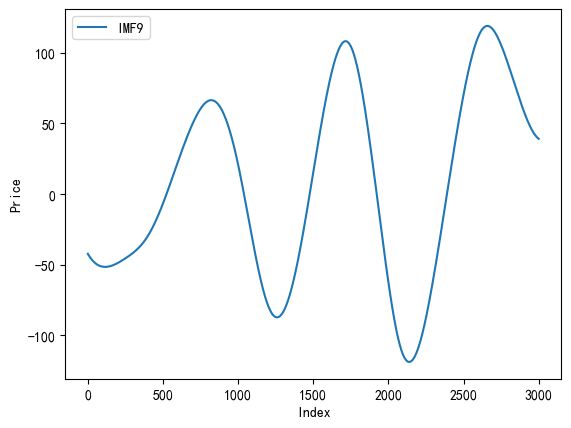

D:\anaconda3\lib\site-packages\keras\initializers\initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_7 (Bidirectio  (None, 3, 128)           33792     
 nal)                                                            
                                                                 
 Attention (SeqSelfAttention  (None, 3, 128)           8257      
 )                                                               
                                                                 
 tcn_7 (TCN)                 (None, 32)                26912     
                                                                 
 dropout_7 (Dropout)         (None, 32)                0         
                                                                 
 activation_7 (Activation)   (None, 32)                0         
                                                                 
 dense_7 (Dense)             (None, 1)                

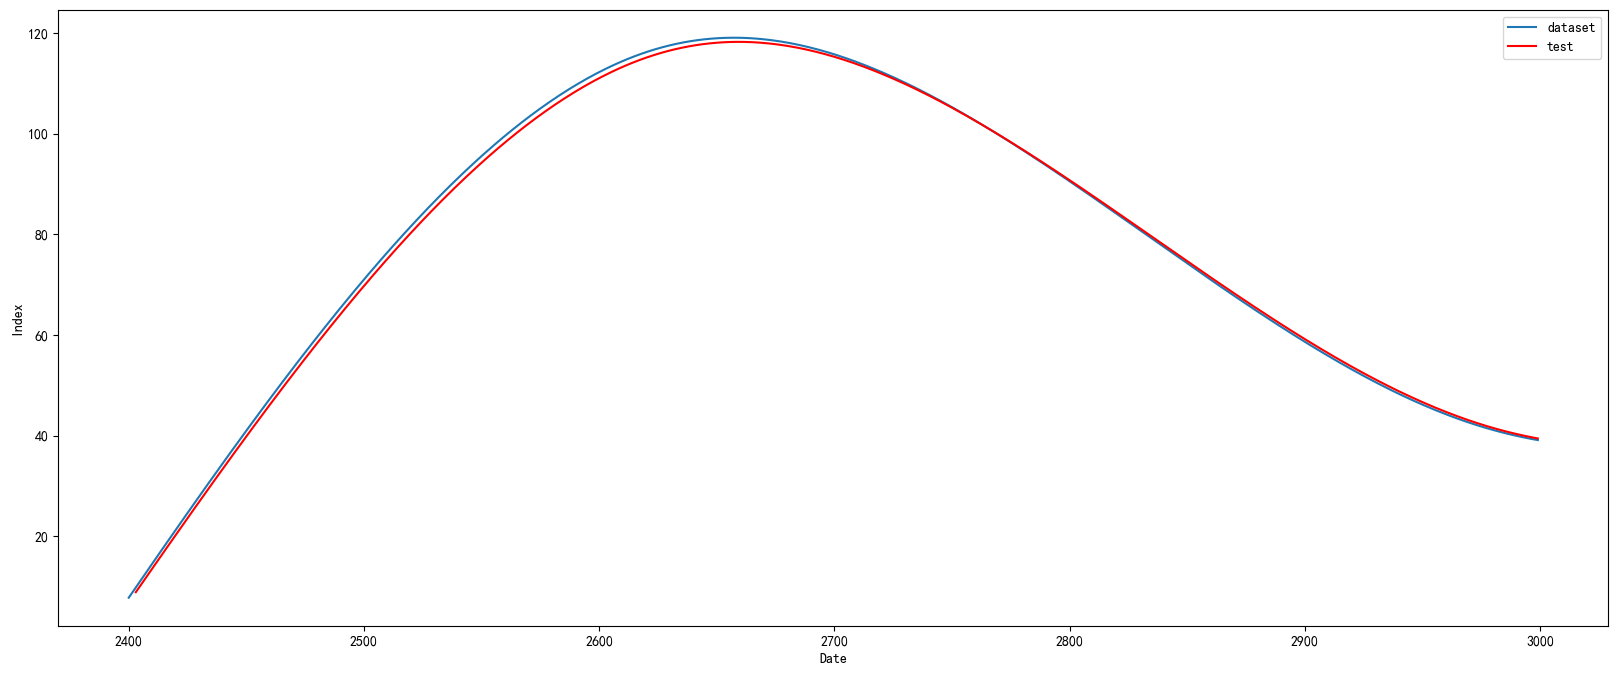

In [9]:
seed_value = 5
np.random.seed(seed_value)
random.seed(seed_value)
tf.random.set_seed(seed_value)
def create_dataset(dataset, look_back):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)
 
def mape(y_true, y_pred):
    n = len(y_true)
    mape = sum(np.abs((y_true - y_pred) / y_true)) / n * 100
    return mape
dataframe = read_csv('./ICEEMDAN S&P 500 Index Low modes_data.csv', index_col=0,usecols=[0,9])
dataset = dataframe.values
dataset = dataset.astype('float32') 
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False
plt.figure(figsize=(20,8))
dataframe.plot()
plt.xlabel('Index')
plt.ylabel('Price')
plt.yticks()
plt.legend()
plt.show()
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset.reshape(-1, 1))
train_size = int(len(dataset) * 0.8) 
test_size = len(dataset) - train_size 
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1)) 

model = Sequential()
model.add(Bidirectional(LSTM(64,return_sequences=True), input_shape=(look_back, 1)))
model.add(SeqSelfAttention(attention_activation='sigmoid', name='Attention'))
model.add(TCN(nb_filters=32, kernel_size=2, nb_stacks=1, dilations=(1, 2, 4, 8), padding='causal', use_skip_connections=True, dropout_rate=0.2, return_sequences=False, activation='linear', kernel_initializer='he_normal', use_batch_norm=False))
model.add(Dropout(0.2))
model.add(Activation('relu'))
model.add(Dense(1)) 
model.compile(loss="mse", optimizer="adam",metrics=['mae']) 
model.summary()
early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1, restore_best_weights=True)
history = model.fit(trainX, trainY, batch_size=32, epochs=100, validation_split=0.1, verbose=1, callbacks=[early_stopping])
scores=model.evaluate(trainX, trainY) 
print(scores[0],scores[1])  
testPredict = model.predict(testX)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict) 
testY = scaler.inverse_transform([testY])
IMF9_pre= pd.DataFrame(testPredict)
IMF9_true= pd.DataFrame(testY[0])

testScore_2= mape(testY[0], testPredict[:, 0])
print('Test Sccore %.4f MAPE' %(testScore_2))
testScore_0 = mean_absolute_error(testY[0], testPredict[:,0])
print('Test Score: %.4f MAE' % (testScore_0))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.4f RMSE' % (testScore))

testPredictPlot = np.empty_like(dataset) 
testPredictPlot[:, :] = np.nan
testPredictPlot = np.reshape(testPredictPlot, (dataset.shape[0], 1)) 
testPredictPlot[train_size-look_back+(look_back*2):len(dataset)+1, :] = testPredict 
plt.figure(figsize=(20,8))
plt.plot( np.arange(train_size, len(dataset), 1),scaler.inverse_transform(dataset)[train_size:], label='dataset')
plt.plot(testPredictPlot,color='r', label='test')
plt.ylabel('Index')
plt.xlabel('Date')
plt.legend()
plt.show()

# Res

<Figure size 2000x800 with 0 Axes>

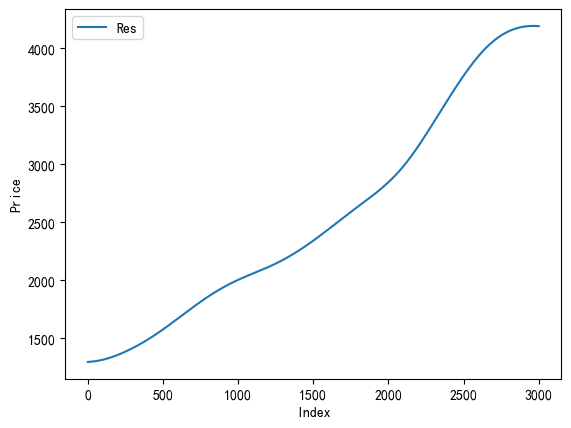

D:\anaconda3\lib\site-packages\keras\initializers\initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_8 (Bidirectio  (None, 3, 64)            8704      
 nal)                                                            
                                                                 
 Attention (SeqSelfAttention  (None, 3, 64)            4161      
 )                                                               
                                                                 
 tcn_8 (TCN)                 (None, 32)                20768     
                                                                 
 dropout_8 (Dropout)         (None, 32)                0         
                                                                 
 activation_8 (Activation)   (None, 32)                0         
                                                                 
 dense_8 (Dense)             (None, 1)                

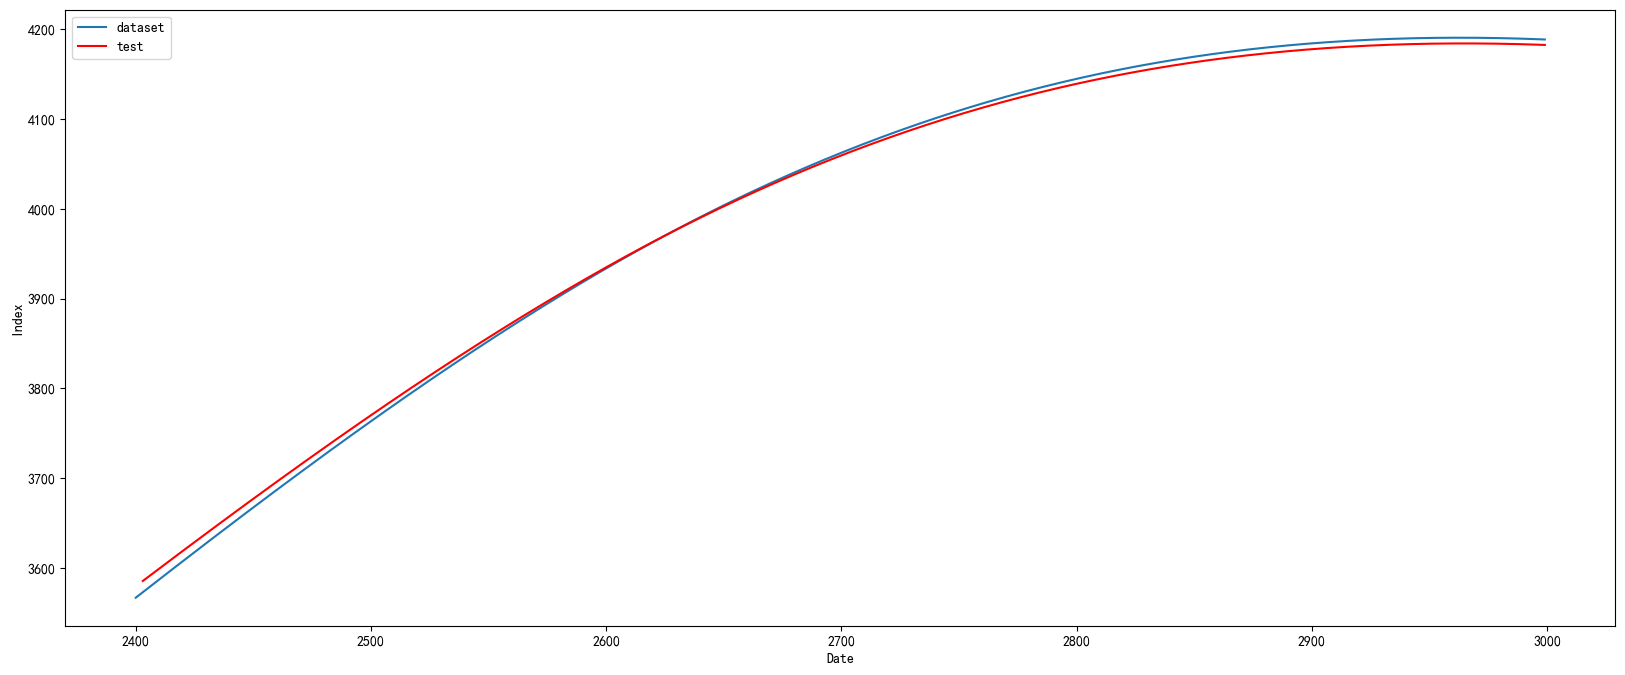

In [10]:
seed_value = 5
np.random.seed(seed_value)
random.seed(seed_value)
tf.random.set_seed(seed_value)
def create_dataset(dataset, look_back):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)
 
def mape(y_true, y_pred):
    n = len(y_true)
    mape = sum(np.abs((y_true - y_pred) / y_true)) / n * 100
    return mape
dataframe = read_csv('./ICEEMDAN S&P 500 Index Low modes_data.csv', index_col=0,usecols=[0,10])
dataset = dataframe.values
dataset = dataset.astype('float32') 
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False
plt.figure(figsize=(20,8))
dataframe.plot()
plt.xlabel('Index')
plt.ylabel('Price')
plt.yticks()
plt.legend()
plt.show()
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset.reshape(-1, 1))
train_size = int(len(dataset) * 0.8) 
test_size = len(dataset) - train_size 
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1)) 

model = Sequential()
model.add(Bidirectional(LSTM(32,return_sequences=True), input_shape=(look_back, 1)))
model.add(SeqSelfAttention(attention_activation='sigmoid', name='Attention'))
model.add(TCN(nb_filters=32, kernel_size=2, nb_stacks=1, dilations=(1, 2, 4, 8), padding='causal', use_skip_connections=True, dropout_rate=0.2, return_sequences=False, activation='linear', kernel_initializer='he_normal', use_batch_norm=False))
model.add(Dropout(0.2))
model.add(Activation('relu'))
model.add(Dense(1)) 
model.compile(loss="mse", optimizer="adam",metrics=['mae']) 
model.summary()
early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1, restore_best_weights=True)
history = model.fit(trainX, trainY, batch_size=32, epochs=100, validation_split=0.1, verbose=1, callbacks=[early_stopping])
scores=model.evaluate(trainX, trainY) 
print(scores[0],scores[1])  
testPredict = model.predict(testX)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict) 
testY = scaler.inverse_transform([testY])
Res_pre= pd.DataFrame(testPredict)
Res_true= pd.DataFrame(testY[0])

testScore_2= mape(testY[0], testPredict[:, 0])
print('Test Sccore %.4f MAPE' %(testScore_2))
testScore_0 = mean_absolute_error(testY[0], testPredict[:,0])
print('Test Score: %.4f MAE' % (testScore_0))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.4f RMSE' % (testScore))

testPredictPlot = np.empty_like(dataset) 
testPredictPlot[:, :] = np.nan
testPredictPlot = np.reshape(testPredictPlot, (dataset.shape[0], 1)) 
testPredictPlot[train_size-look_back+(look_back*2):len(dataset)+1, :] = testPredict 
plt.figure(figsize=(20,8))
plt.plot( np.arange(train_size, len(dataset), 1),scaler.inverse_transform(dataset)[train_size:], label='dataset')
plt.plot(testPredictPlot,color='r', label='test')
plt.ylabel('Index')
plt.xlabel('Date')
plt.legend()
plt.show()

# VIMF1

<Figure size 2000x800 with 0 Axes>

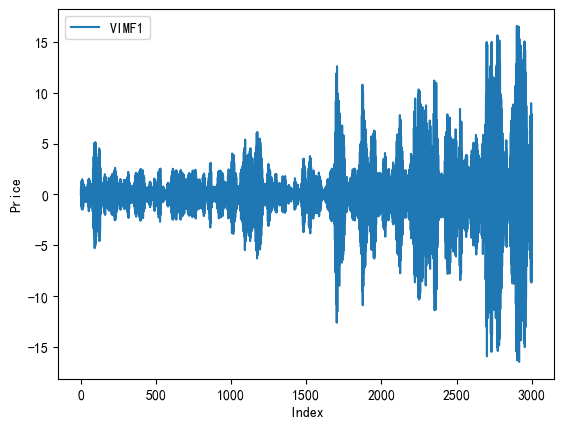

D:\anaconda3\lib\site-packages\keras\initializers\initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_9 (Bidirectio  (None, 3, 128)           33792     
 nal)                                                            
                                                                 
 Attention (SeqSelfAttention  (None, 3, 128)           8257      
 )                                                               
                                                                 
 tcn_9 (TCN)                 (None, 32)                26912     
                                                                 
 dropout_9 (Dropout)         (None, 32)                0         
                                                                 
 activation_9 (Activation)   (None, 32)                0         
                                                                 
 dense_9 (Dense)             (None, 1)                

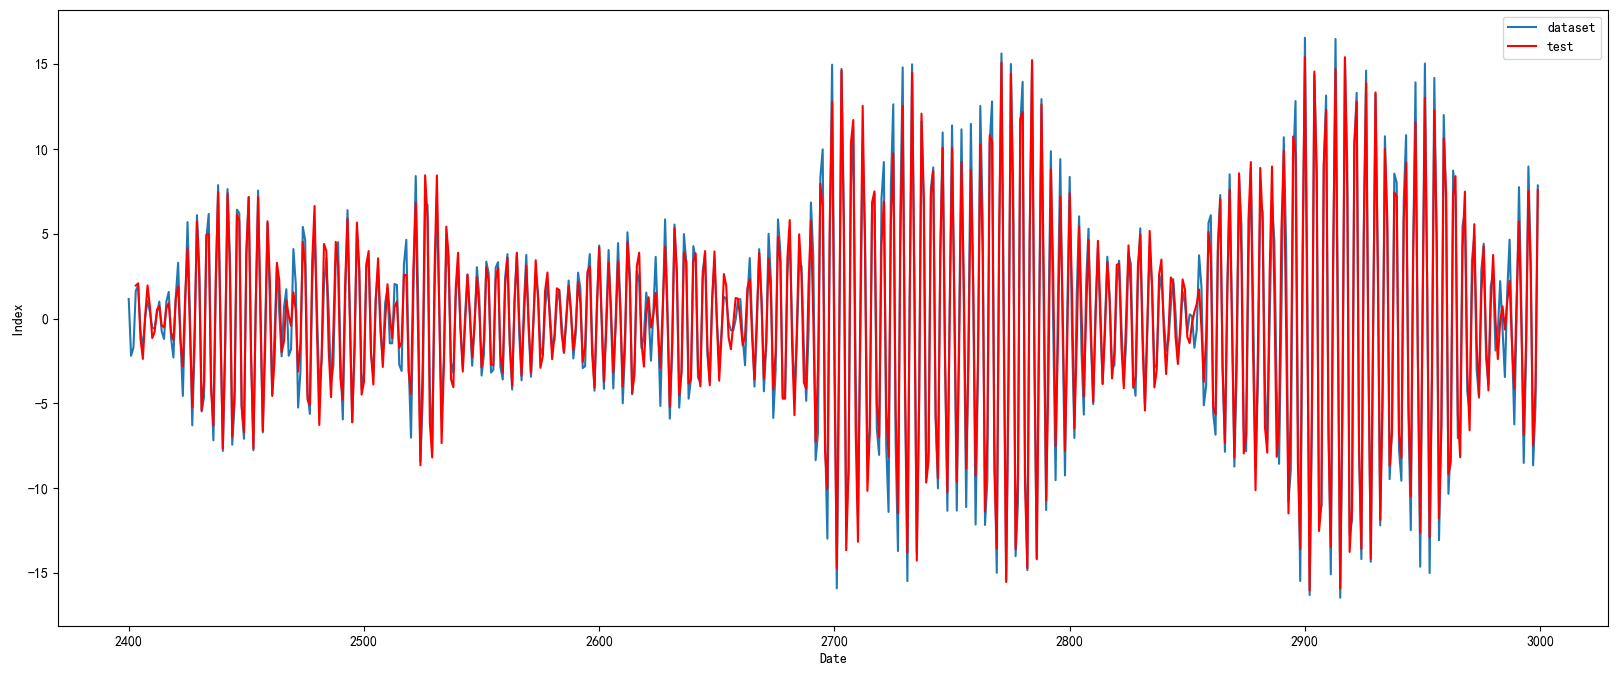

In [11]:
seed_value = 5
np.random.seed(seed_value)
random.seed(seed_value)
tf.random.set_seed(seed_value)
def create_dataset(dataset, look_back):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)
 
def mape(y_true, y_pred):
    n = len(y_true)
    mape = sum(np.abs((y_true - y_pred) / y_true)) / n * 100
    return mape
dataframe = read_csv('./S&P 500 Index Low VIMFs.csv', index_col=0,usecols=[0,1])
dataset = dataframe.values
dataset = dataset.astype('float32') 
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False
plt.figure(figsize=(20,8))
dataframe.plot()
plt.xlabel('Index')
plt.ylabel('Price')
plt.yticks()
plt.legend()
plt.show()
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset.reshape(-1, 1))
train_size = int(len(dataset) * 0.8) 
test_size = len(dataset) - train_size 
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1)) 

model = Sequential()
model.add(Bidirectional(LSTM(64,return_sequences=True), input_shape=(look_back, 1)))
model.add(SeqSelfAttention(attention_activation='sigmoid', name='Attention'))
model.add(TCN(nb_filters=32, kernel_size=2, nb_stacks=1, dilations=(1, 2, 4, 8), padding='causal', use_skip_connections=True, dropout_rate=0.2, return_sequences=False, activation='linear', kernel_initializer='he_normal', use_batch_norm=False))
model.add(Dropout(0.2))
model.add(Activation('relu'))
model.add(Dense(1)) 
model.compile(loss="mse", optimizer="adam",metrics=['mae']) 
model.summary()
early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1, restore_best_weights=True)
history = model.fit(trainX, trainY, batch_size=32, epochs=100, validation_split=0.1, verbose=1, callbacks=[early_stopping])
scores=model.evaluate(trainX, trainY) 
print(scores[0],scores[1])  
testPredict = model.predict(testX)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict) 
testY = scaler.inverse_transform([testY])
VIMF1_pre= pd.DataFrame(testPredict)
VIMF1_true= pd.DataFrame(testY[0])

testScore_2= mape(testY[0], testPredict[:, 0])
print('Test Sccore %.4f MAPE' %(testScore_2))
testScore_0 = mean_absolute_error(testY[0], testPredict[:,0])
print('Test Score: %.4f MAE' % (testScore_0))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.4f RMSE' % (testScore))

testPredictPlot = np.empty_like(dataset) 
testPredictPlot[:, :] = np.nan
testPredictPlot = np.reshape(testPredictPlot, (dataset.shape[0], 1)) 
testPredictPlot[train_size-look_back+(look_back*2):len(dataset)+1, :] = testPredict 
plt.figure(figsize=(20,8))
plt.plot( np.arange(train_size, len(dataset), 1),scaler.inverse_transform(dataset)[train_size:], label='dataset')
plt.plot(testPredictPlot,color='r', label='test')
plt.ylabel('Index')
plt.xlabel('Date')
plt.legend()
plt.show()

# VIMF2

<Figure size 2000x800 with 0 Axes>

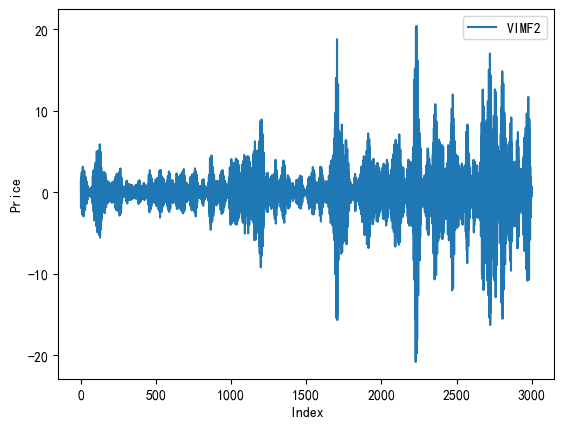

D:\anaconda3\lib\site-packages\keras\initializers\initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_10 (Bidirecti  (None, 3, 128)           33792     
 onal)                                                           
                                                                 
 Attention (SeqSelfAttention  (None, 3, 128)           8257      
 )                                                               
                                                                 
 tcn_10 (TCN)                (None, 32)                26912     
                                                                 
 dropout_10 (Dropout)        (None, 32)                0         
                                                                 
 activation_10 (Activation)  (None, 32)                0         
                                                                 
 dense_10 (Dense)            (None, 1)               

Epoch 52/200
68/68 [==============================] - 1s 10ms/step - loss: 6.0407e-04 - mae: 0.0186 - val_loss: 8.4364e-04 - val_mae: 0.0211
Epoch 53/200
68/68 [==============================] - 1s 10ms/step - loss: 4.1365e-04 - mae: 0.0149 - val_loss: 0.0010 - val_mae: 0.0220
Epoch 54/200
68/68 [==============================] - 1s 10ms/step - loss: 4.1501e-04 - mae: 0.0146 - val_loss: 0.0010 - val_mae: 0.0217
Epoch 55/200
68/68 [==============================] - 1s 9ms/step - loss: 4.0443e-04 - mae: 0.0143 - val_loss: 0.0013 - val_mae: 0.0239
Epoch 56/200
68/68 [==============================] - 1s 9ms/step - loss: 3.4858e-04 - mae: 0.0134 - val_loss: 8.8036e-04 - val_mae: 0.0197
Epoch 57/200
68/68 [==============================] - 1s 9ms/step - loss: 4.3593e-04 - mae: 0.0154 - val_loss: 9.3170e-04 - val_mae: 0.0218
Epoch 58/200
68/68 [==============================] - 1s 9ms/step - loss: 4.5019e-04 - mae: 0.0157 - val_loss: 8.5752e-04 - val_mae: 0.0198
Epoch 59/200
68/68 [=========

68/68 [==============================] - 1s 9ms/step - loss: 2.5598e-04 - mae: 0.0110 - val_loss: 4.8080e-04 - val_mae: 0.0152
Epoch 111/200
68/68 [==============================] - 1s 9ms/step - loss: 3.0714e-04 - mae: 0.0118 - val_loss: 0.0011 - val_mae: 0.0224
Epoch 112/200
68/68 [==============================] - 1s 9ms/step - loss: 3.1047e-04 - mae: 0.0126 - val_loss: 5.9998e-04 - val_mae: 0.0167
Epoch 113/200
68/68 [==============================] - 1s 10ms/step - loss: 2.6193e-04 - mae: 0.0115 - val_loss: 7.5965e-04 - val_mae: 0.0183
Epoch 114/200
68/68 [==============================] - 1s 10ms/step - loss: 2.5403e-04 - mae: 0.0108 - val_loss: 8.6285e-04 - val_mae: 0.0199
Epoch 115/200
68/68 [==============================] - 1s 9ms/step - loss: 2.3534e-04 - mae: 0.0106 - val_loss: 5.4558e-04 - val_mae: 0.0159
Epoch 116/200
68/68 [==============================] - 1s 9ms/step - loss: 2.8641e-04 - mae: 0.0120 - val_loss: 5.7548e-04 - val_mae: 0.0160
Epoch 117/200
68/68 [========

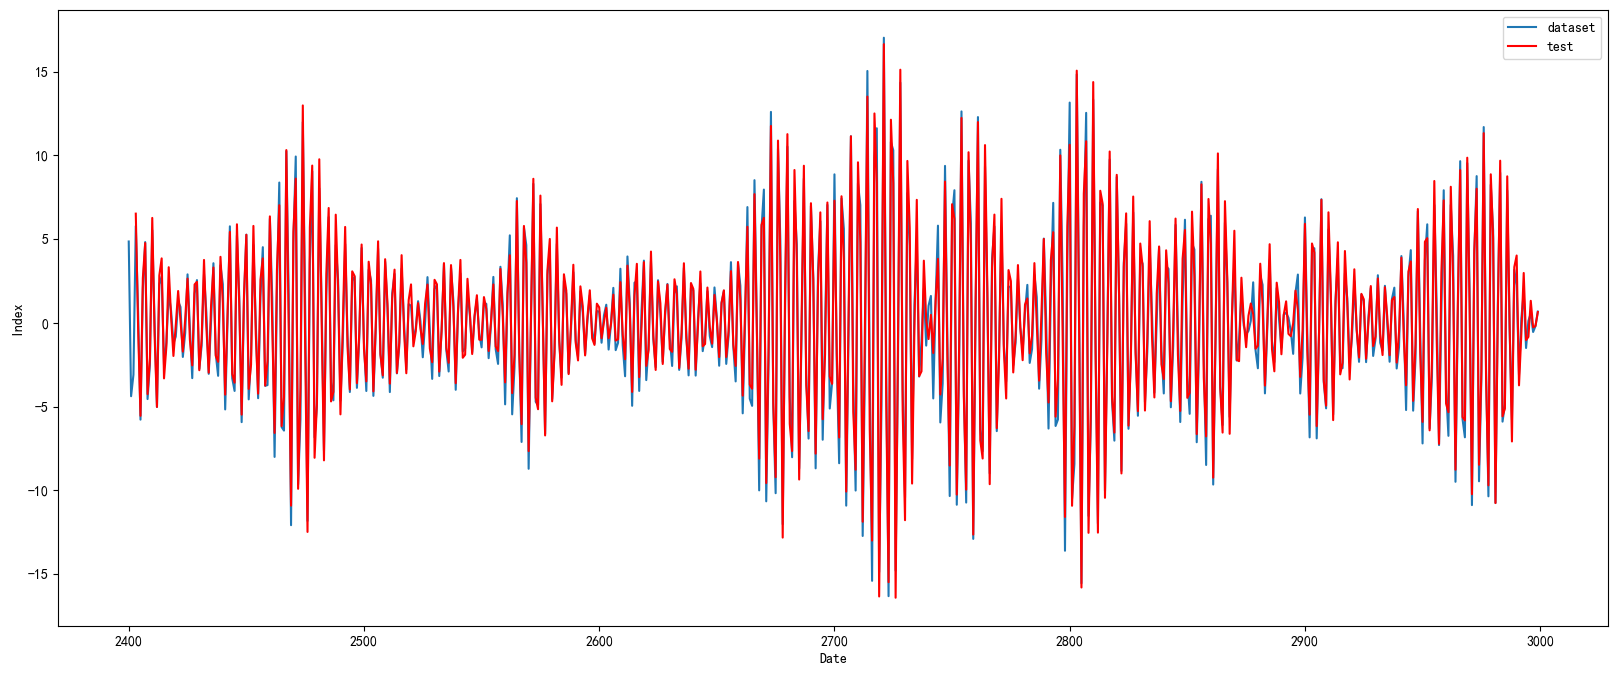

In [12]:
seed_value = 42
np.random.seed(seed_value)
random.seed(seed_value)
tf.random.set_seed(seed_value)
def create_dataset(dataset, look_back):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)
 
def mape(y_true, y_pred):
    n = len(y_true)
    mape = sum(np.abs((y_true - y_pred) / y_true)) / n * 100
    return mape
dataframe = read_csv('./S&P 500 Index Low VIMFs.csv', index_col=0,usecols=[0,2])
dataset = dataframe.values
dataset = dataset.astype('float32') 
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False
plt.figure(figsize=(20,8))
dataframe.plot()
plt.xlabel('Index')
plt.ylabel('Price')
plt.yticks()
plt.legend()
plt.show()
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset.reshape(-1, 1))
train_size = int(len(dataset) * 0.8) 
test_size = len(dataset) - train_size 
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1)) 

model = Sequential()
model.add(Bidirectional(LSTM(64,return_sequences=True), input_shape=(look_back, 1)))
model.add(SeqSelfAttention(attention_activation='sigmoid', name='Attention'))
model.add(TCN(nb_filters=32, kernel_size=2, nb_stacks=1, dilations=(1, 2, 4, 8), padding='causal', use_skip_connections=True, dropout_rate=0.2, return_sequences=False, activation='linear', kernel_initializer='he_normal', use_batch_norm=False))
model.add(Dropout(0.2))
model.add(Activation('relu'))
model.add(Dense(1)) 
model.compile(loss="mse", optimizer="adam",metrics=['mae']) 
model.summary()
early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1, restore_best_weights=True)
history = model.fit(trainX, trainY, batch_size=32, epochs=200, validation_split=0.1, verbose=1, callbacks=[early_stopping])
scores=model.evaluate(trainX, trainY) 
print(scores[0],scores[1])  
testPredict = model.predict(testX)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict) 
testY = scaler.inverse_transform([testY])
VIMF2_pre= pd.DataFrame(testPredict)
VIMF2_true= pd.DataFrame(testY[0])

testScore_2= mape(testY[0], testPredict[:, 0])
print('Test Sccore %.4f MAPE' %(testScore_2))
testScore_0 = mean_absolute_error(testY[0], testPredict[:,0])
print('Test Score: %.4f MAE' % (testScore_0))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.4f RMSE' % (testScore))

testPredictPlot = np.empty_like(dataset) 
testPredictPlot[:, :] = np.nan
testPredictPlot = np.reshape(testPredictPlot, (dataset.shape[0], 1)) 
testPredictPlot[train_size-look_back+(look_back*2):len(dataset)+1, :] = testPredict 
plt.figure(figsize=(20,8))
plt.plot( np.arange(train_size, len(dataset), 1),scaler.inverse_transform(dataset)[train_size:], label='dataset')
plt.plot(testPredictPlot,color='r', label='test')
plt.ylabel('Index')
plt.xlabel('Date')
plt.legend()
plt.show()

# VIMF3

<Figure size 2000x800 with 0 Axes>

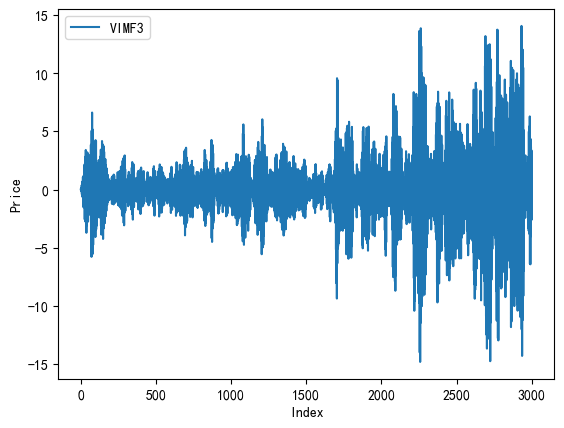

D:\anaconda3\lib\site-packages\keras\initializers\initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_11 (Bidirecti  (None, 3, 128)           33792     
 onal)                                                           
                                                                 
 Attention (SeqSelfAttention  (None, 3, 128)           8257      
 )                                                               
                                                                 
 tcn_11 (TCN)                (None, 32)                26912     
                                                                 
 dropout_11 (Dropout)        (None, 32)                0         
                                                                 
 activation_11 (Activation)  (None, 32)                0         
                                                                 
 dense_11 (Dense)            (None, 1)               

68/68 [==============================] - 1s 9ms/step - loss: 5.7621e-04 - mae: 0.0179 - val_loss: 0.0017 - val_mae: 0.0308
Epoch 53/100
68/68 [==============================] - 1s 9ms/step - loss: 5.3792e-04 - mae: 0.0173 - val_loss: 0.0016 - val_mae: 0.0299
Epoch 54/100
68/68 [==============================] - 1s 9ms/step - loss: 5.8967e-04 - mae: 0.0183 - val_loss: 0.0017 - val_mae: 0.0309
Epoch 55/100
68/68 [==============================] - 1s 9ms/step - loss: 4.7913e-04 - mae: 0.0160 - val_loss: 0.0018 - val_mae: 0.0320
Epoch 56/100
68/68 [==============================] - 1s 9ms/step - loss: 4.8810e-04 - mae: 0.0166 - val_loss: 0.0018 - val_mae: 0.0321
Epoch 57/100
68/68 [==============================] - 1s 9ms/step - loss: 5.0870e-04 - mae: 0.0168 - val_loss: 0.0014 - val_mae: 0.0282
Epoch 58/100
68/68 [==============================] - 1s 9ms/step - loss: 4.9221e-04 - mae: 0.0162 - val_loss: 0.0016 - val_mae: 0.0306
Epoch 59/100
68/68 [==============================] - 1s 9ms/

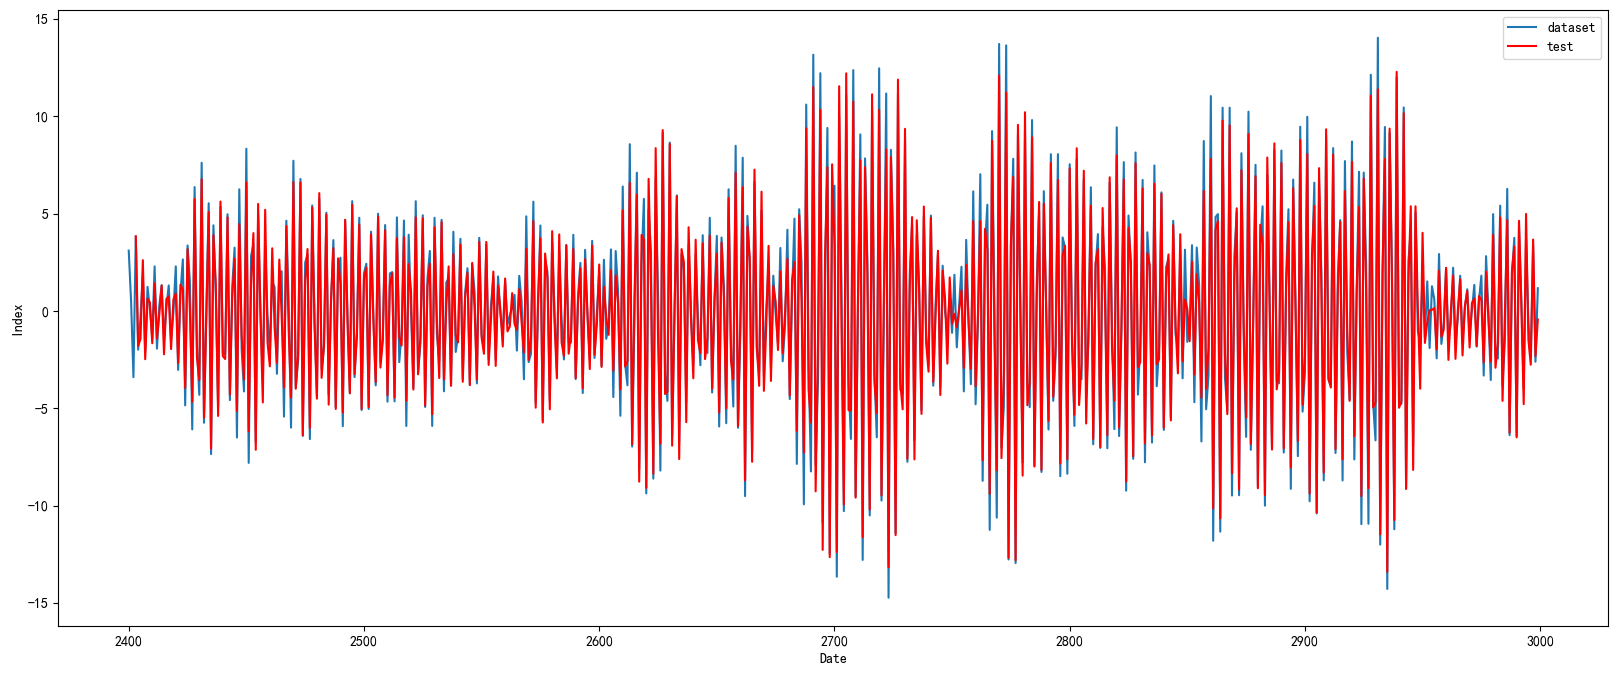

In [13]:
seed_value = 42
np.random.seed(seed_value)
random.seed(seed_value)
tf.random.set_seed(seed_value)
def create_dataset(dataset, look_back):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)
 
def mape(y_true, y_pred):
    n = len(y_true)
    mape = sum(np.abs((y_true - y_pred) / y_true)) / n * 100
    return mape
dataframe = read_csv('./S&P 500 Index Low VIMFs.csv', index_col=0,usecols=[0,3])
dataset = dataframe.values
dataset = dataset.astype('float32') 
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False
plt.figure(figsize=(20,8))
dataframe.plot()
plt.xlabel('Index')
plt.ylabel('Price')
plt.yticks()
plt.legend()
plt.show()
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset.reshape(-1, 1))
train_size = int(len(dataset) * 0.8) 
test_size = len(dataset) - train_size 
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1)) 

model = Sequential()
model.add(Bidirectional(LSTM(64,return_sequences=True), input_shape=(look_back, 1)))
model.add(SeqSelfAttention(attention_activation='sigmoid', name='Attention'))
model.add(TCN(nb_filters=32, kernel_size=2, nb_stacks=1, dilations=(1, 2, 4, 8), padding='causal', use_skip_connections=True, dropout_rate=0.2, return_sequences=False, activation='linear', kernel_initializer='he_normal', use_batch_norm=False))
model.add(Dropout(0.2))
model.add(Activation('relu'))
model.add(Dense(1)) 
model.compile(loss="mse", optimizer="adam",metrics=['mae']) 
model.summary()
early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1, restore_best_weights=True)
history = model.fit(trainX, trainY, batch_size=32, epochs=100, validation_split=0.1, verbose=1, callbacks=[early_stopping])
scores=model.evaluate(trainX, trainY) 
print(scores[0],scores[1])  
testPredict = model.predict(testX)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict) 
testY = scaler.inverse_transform([testY])
VIMF3_pre= pd.DataFrame(testPredict)
VIMF3_true= pd.DataFrame(testY[0])

testScore_2= mape(testY[0], testPredict[:, 0])
print('Test Sccore %.4f MAPE' %(testScore_2))
testScore_0 = mean_absolute_error(testY[0], testPredict[:,0])
print('Test Score: %.4f MAE' % (testScore_0))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.4f RMSE' % (testScore))

testPredictPlot = np.empty_like(dataset) 
testPredictPlot[:, :] = np.nan
testPredictPlot = np.reshape(testPredictPlot, (dataset.shape[0], 1)) 
testPredictPlot[train_size-look_back+(look_back*2):len(dataset)+1, :] = testPredict 
plt.figure(figsize=(20,8))
plt.plot( np.arange(train_size, len(dataset), 1),scaler.inverse_transform(dataset)[train_size:], label='dataset')
plt.plot(testPredictPlot,color='r', label='test')
plt.ylabel('Index')
plt.xlabel('Date')
plt.legend()
plt.show()

# Original

<Figure size 2000x800 with 0 Axes>

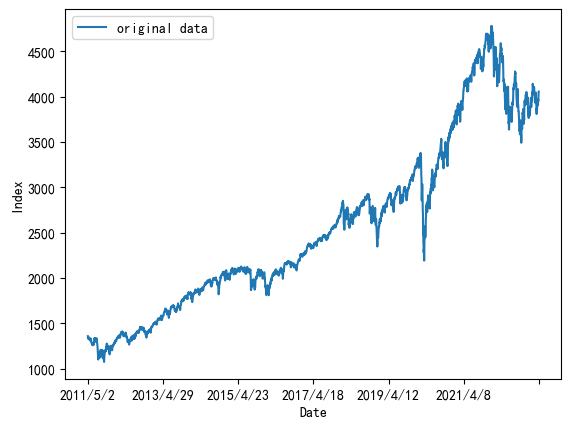

In [14]:
seed_value = 42
np.random.seed(seed_value)
random.seed(seed_value)
tf.random.set_seed(seed_value)
def create_dataset(dataset, look_back):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)
dataframe = read_csv('./S&P 500 Index Low.csv', index_col=0,usecols=[0,1])
dataset = dataframe.values
dataset = dataset.astype('float32')
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False
plt.figure(figsize=(20,8))
dataframe.plot()
plt.xlabel('Date')
plt.ylabel('Index')
plt.yticks()
plt.legend(['original data'])
plt.show()
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset.reshape(-1, 1))
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size 
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :] 


trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back) 

trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))


testY = scaler.inverse_transform([testY])

Original_pre= pd.DataFrame(testPredict)
Original_true= pd.DataFrame(testY[0])

In [15]:
testPredict=pd.concat([IMF2_pre,
                       IMF3_pre,
                       IMF4_pre,
                       IMF5_pre,
                       IMF6_pre,
                       IMF7_pre,
                       IMF8_pre,
                       IMF9_pre,
                       Res_pre,
                       VIMF1_pre,
                       VIMF2_pre,
                       VIMF3_pre,],axis=1)  # 横向合并


testPredict["pre_sum"]=testPredict.sum(axis=1)

testPredict["Original_true"]=Original_true

In [16]:
testScore_2= mape(testPredict["Original_true"], testPredict["pre_sum"])
print('Test Sccore %.4f MAPE' %(testScore_2))
testScore_0 = mean_absolute_error(testPredict["Original_true"], testPredict["pre_sum"])
print('Test Score: %.4f MAE' % (testScore_0))
testScore = math.sqrt(mean_squared_error(testPredict["Original_true"], testPredict["pre_sum"]))
print('Test Score: %.4f RMSE' % (testScore))

Test Sccore 0.5073 MAPE
Test Score: 20.5042 MAE
Test Score: 27.5569 RMSE


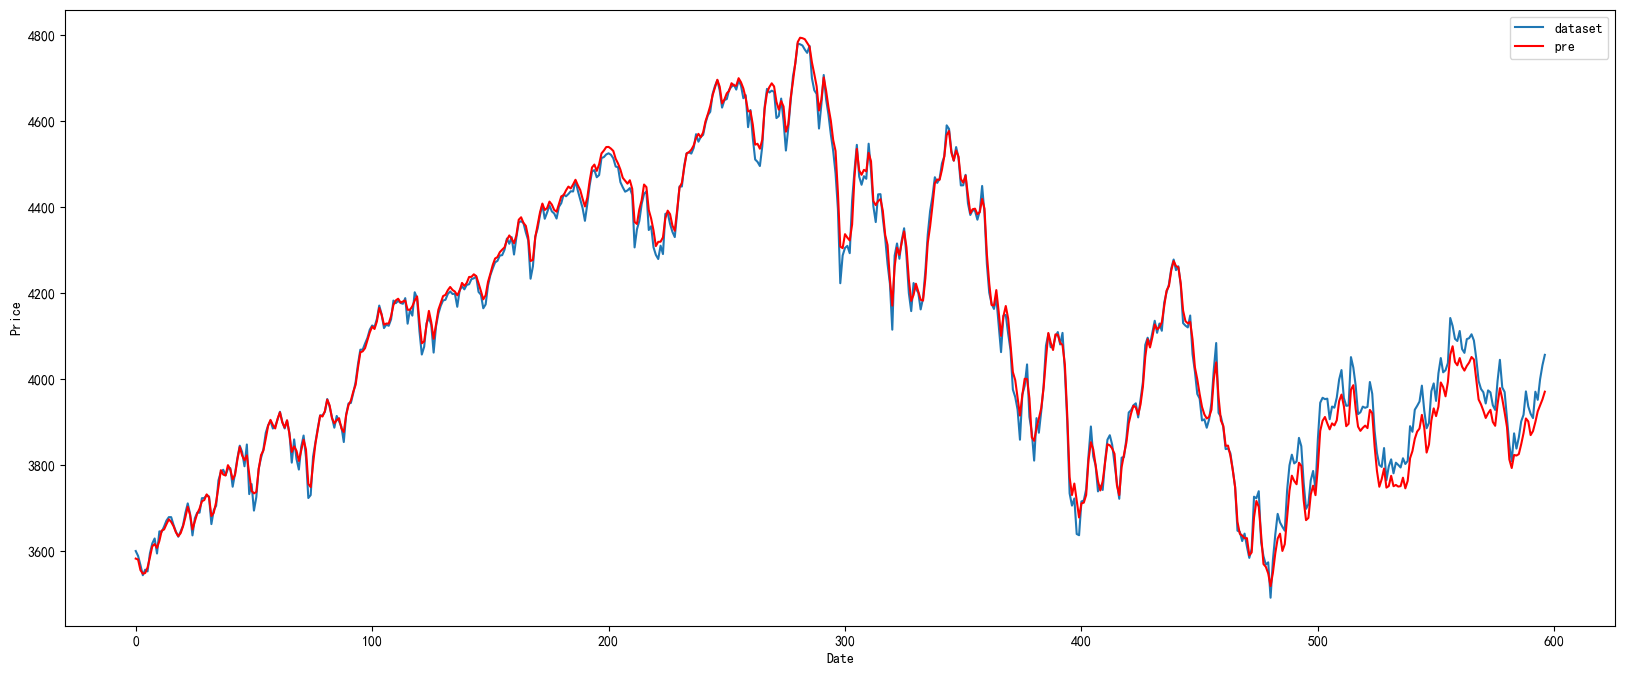

In [17]:
plt.figure(figsize=(20,8))
plt.plot(testPredict["Original_true"], label='dataset')
plt.plot(testPredict["pre_sum"],color='r', label='pre')
plt.ylabel('Price')
plt.xlabel('Date')
plt.legend()
plt.show()

In [18]:
# 最终集成并写入csv
Finally_excel=testPredict

Finally_excel.to_csv('./Finally_excel.csv')

In [19]:
end_time = time.time()
execution_time = end_time - start_time
print("Execution time: {:.2f} seconds".format(execution_time))

Execution time: 800.91 seconds
